In [1]:
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import Chem
from rdkit.Chem import AllChem
import os
import pandas as pd
import argparse
import pickle
import os
import sys
import torch
import rdkit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
import json
import pickle
from sklearn.model_selection import train_test_split

In [2]:
np.__version__

Out[2]: '1.16.4'

In [3]:
%run /Users/vxjdk@leo-pharma.com/mol_utils

In [4]:
datasets = ["Homopiperazines","Piperazines","Piperidines","Sulphamides"]
names = ["JAK1 EC50 nM 1027","JAK2 EC50 nM 1024","JAK3 EC50 nM 1026"]
names = names + ['TYK2 EC50 nM 1025']
files = ["/dbfs/FileStore/tables/Homopiperazines_cleaned_Feb_2019.sdf",
         "/dbfs/FileStore/tables/Piperazines_cleaned_Feb_2019.sdf",
         "/dbfs/FileStore/tables/Piperidines_cleaned_Feb_2019.sdf",
         "/dbfs/FileStore/tables/Sulphamides_cleaned_Feb_2019.sdf",
        ]
PARENT_DIR = '/dbfs/FileStore/tables'
PICKLES_DIR = '/dbfs/FileStore/pickles'
MOSES_DIR = '/dbfs/FileStore/moses'
CHEMPROP_DIR = '/dbfs/FileStore/chemprop'

ZINC_DIR = '/dbfs/FileStore/ZINC'
ZINC_Models = os.path.join(ZINC_DIR,'models')
VIRTUAL_SCREENING = os.path.join(ZINC_DIR,'virtual_screening')
targets=['JAK1','JAK2','JAK3','TYK2']

G2G = '/dbfs/FileStore/g2g'
TENSORS = os.path.join(G2G,'tensors')
dest = 'median-train_pairs'
datasets = ['dpEC1-all_pairs-JAK1.txt', 
            'dpEC1-all_pairs-JAK2.txt', 
            'dpEC1-all_pairs-JAK3.txt', 
            'dpEC1-all_pairs-TYK2.txt', 
            'dpEC1-close_pairs-JAK1.txt', 
            'dpEC1-close_pairs-JAK2.txt', 
            'dpEC1-close_pairs-JAK3.txt', 
            'dpEC1-close_pairs-TYK2.txt', 
            'dpEC1to2-all_pairs-JAK1.txt', 
            'dpEC1to2-all_pairs-JAK2.txt', 
            'dpEC1to2-all_pairs-JAK3.txt', 
            'dpEC1to2-all_pairs-TYK2.txt', 
            'dpEC1to2-close_pairs-JAK1.txt', 
            'dpEC1to2-close_pairs-JAK2.txt', 
            'dpEC1to2-close_pairs-JAK3.txt', 
            'dpEC1to2-close_pairs-TYK2.txt', 
            'median-all_pairs-JAK1.txt', 
            'median-all_pairs-JAK2.txt', 
            'median-all_pairs-JAK3.txt', 
            'median-all_pairs-TYK2.txt', 
            'median-close_pairs-JAK1.txt', 
            'median-close_pairs-JAK2.txt', 
            'median-close_pairs-JAK3.txt', 
            'median-close_pairs-TYK2.txt', 
            'pEC7.6-all_pairs-JAK1.txt', 
            'pEC7.6-all_pairs-JAK2.txt', 
            'pEC7.6-all_pairs-JAK3.txt', 
            'pEC7.6-all_pairs-TYK2.txt', 
            'pEC7.6-close_pairs-JAK1.txt', 
            'pEC7.6-close_pairs-JAK2.txt', 
            'pEC7.6-close_pairs-JAK3.txt', 
            'pEC7.6-close_pairs-TYK2.txt']

In [5]:
%sh wc -l /dbfs/FileStore/g2g/validation_set-all_targets.smi

182 /dbfs/FileStore/g2g/validation_set-all_targets.smi

# Paired dataset preparation

In [7]:
frames = []
for j, file in enumerate(files):
  frame = PandasTools.LoadSDF(file,isomericSmiles=True,
                              smilesName='SMILES',molColName='Molecule', includeFingerprints=False)
  frame.replace('newline',np.nan, inplace=True)
  frames.append(frame)
frame = pd.concat(frames,ignore_index=True)

/local_disk0/tmp/1566399699654-0/PythonShell.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

 import pickle

In [8]:
for i, name in enumerate(names):
  pl_frame = frame.dropna(subset=[name]).drop_duplicates(subset=['SMILES'])
  with open(os.path.join(G2G, 'molecules-'+name[:4]+'.txt'),'w') as outfile:
    for i,row in pl_frame.iterrows():
      outfile.write(row['SMILES']+'\n')

In [9]:
frame.rename(columns = {name:name[:4] for name in names},inplace=True)

In [10]:
val_test_idx = frame.dropna(subset=[name[:4] for name in names]).sample(frac=0.2).index
val_idx, test_idx = train_test_split(val_test_idx, test_size=0.5,random_state=13)
for name in names:
  frame[name[:4]]=-np.log10(np.array(frame[name[:4]]).astype(float)*1e-9)

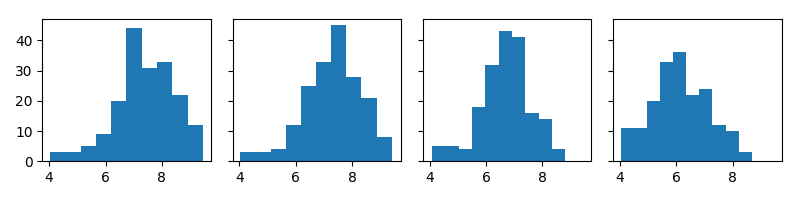

In [11]:
f, axes = plt.subplots(1,4,sharex=True, sharey=True,figsize=(8,2))
for i, ax in enumerate(axes):
  ax.hist(frame.iloc[val_idx,:][names[i][:4]])
  
f.tight_layout()
display(f)

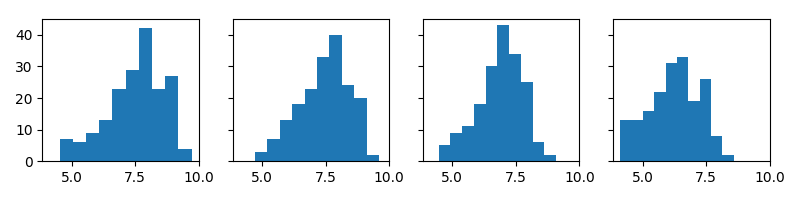

In [12]:
f, axes = plt.subplots(1,4,sharex=True, sharey=True,figsize=(8,2))
for i, ax in enumerate(axes):
  ax.hist(frame.iloc[test_idx,:][names[i][:4]])
  
f.tight_layout()
display(f)

In [13]:
frame.iloc[val_idx,:].filter(['SMILES']+[name[:4] for name in names]).to_csv(os.path.join(G2G, 'validation_set-all_targets.csv'),index=False)
frame.iloc[test_idx,:].filter(['SMILES']+[name[:4] for name in names]).to_csv(os.path.join(G2G, 'test_set-all_targets.csv'))
train_frame = frame[~frame.index.isin(val_test_idx)]
train_frame.filter(['SMILES']+[name[:4] for name in names]).to_csv(os.path.join(G2G, 'train_set-all_targets.csv'))

In [14]:
pd.read_csv(os.path.join(G2G, 'validation_set-all_targets.csv')).iloc[:,:1].to_csv(os.path.join(G2G, 'validation_set-all_targets.smi'),index= False,header=None)
pd.read_csv(os.path.join(G2G, 'test_set-all_targets.csv')).iloc[:,:1].to_csv(os.path.join(G2G, 'test_set-all_targets.smi'),index= False,header=None)
pd.read_csv(os.path.join(G2G, 'train_set-all_targets.csv')).iloc[:,:1].to_csv(os.path.join(G2G, 'train_set-all_targets.smi'),index= False,header=None)

In [15]:
for i, name in enumerate(targets):
  pl_frame = train_frame.dropna(subset=[name]).drop_duplicates(subset=['SMILES'])
  pl_frame['pEC50'] = pl_frame[name]
  median = np.median(pl_frame['pEC50'])
  actives = pl_frame[pl_frame['pEC50']>median].reset_index(drop=True)
  inactives = pl_frame[pl_frame['pEC50']<=median].reset_index(drop=True)
  inactives = inactives[:len(actives)] 
  actives_fps = [FingerprintMols.FingerprintMol(x) for x in actives['Molecule'].tolist()]
  inactives_fps = [FingerprintMols.FingerprintMol(x) for x in inactives['Molecule'].tolist()]
  dists = fps_distances([FingerprintMols.FingerprintMol(x) for x in actives['Molecule'].tolist()]+
                        [FingerprintMols.FingerprintMol(x) for x in inactives['Molecule'].tolist()])
  cost = dists[:len(actives),len(actives):]
  row_ind, col_ind = linear_sum_assignment(cost)
  with open(os.path.join(G2G, 'median-all_pairs-'+str(len(actives))+'-'+name+'.txt'),'w') as outfile:
    
    for row, col in zip(row_ind, col_ind):
      outfile.write(' '.join([inactives['SMILES'][col],actives['SMILES'][row]])+'\n')
  

In [16]:
targets = [name[:4] for name in names]
for i, name in enumerate(targets):
  pl_frame = train_frame.dropna(subset=[name]).drop_duplicates(subset=['SMILES'])
  pl_frame['pEC50'] = pl_frame[name]
  median = np.median(pl_frame['pEC50'])
  actives = pl_frame[pl_frame['pEC50']>median].reset_index(drop=True)
  inactives = pl_frame[pl_frame['pEC50']<=median].reset_index(drop=True)
  with open(os.path.join(G2G, 'median-all_pairs-'+name+'.txt'),'w') as outfile, open(os.path.join(G2G, 'median-close_pairs-'+name+'.txt'),'w') as out_close:
    for i,row in inactives.iterrows():
      close_actives = actives[np.array(DataStructs.BulkTanimotoSimilarity(FingerprintMols.FingerprintMol(row['Molecule']),[FingerprintMols.FingerprintMol(x) for x in actives['Molecule'].tolist()],returnDistance=False))>0.6]
      for smiles in actives['SMILES']:
        outfile.write(' '.join([row['SMILES'],smiles])+'\n')
      for smiles in close_actives['SMILES']:
        out_close.write(' '.join([row['SMILES'],smiles])+'\n')


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
JAK1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187

In [17]:
targets = [name[:4] for name in names]
for i, name in enumerate(targets):
  pl_frame = train_frame.dropna(subset=[name]).drop_duplicates(subset=['SMILES'])
  pl_frame['pEC50'] = pl_frame[name]
  median = 7.6
  actives = pl_frame[pl_frame['pEC50']>median].reset_index(drop=True)
  inactives = pl_frame[pl_frame['pEC50']<=median].reset_index(drop=True)
  with open(os.path.join(G2G, 'pEC7.6-all_pairs-'+name+'.txt'),'w') as outfile, open(os.path.join(G2G, 'pEC7.6-close_pairs-'+name+'.txt'),'w') as out_close:
    for i,row in inactives.iterrows():
      close_actives = actives[np.array(DataStructs.BulkTanimotoSimilarity(FingerprintMols.FingerprintMol(row['Molecule']),[FingerprintMols.FingerprintMol(x) for x in actives['Molecule'].tolist()],returnDistance=False))>0.6]
      for smiles in actives['SMILES']:
        outfile.write(' '.join([row['SMILES'],smiles])+'\n')
      for smiles in close_actives['SMILES']:
        out_close.write(' '.join([row['SMILES'],smiles])+'\n')


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
JAK1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47

In [18]:

for i, name in enumerate(targets):
  pl_frame = train_frame.dropna(subset=[name]).drop_duplicates(subset=['SMILES'])
  pl_frame['pEC50'] = pl_frame[name]
  with open(os.path.join(G2G, 'dpEC1-all_pairs-'+name+'.txt'),'w') as outfile, open(os.path.join(G2G, 'dpEC1-close_pairs-'+name+'.txt'),'w') as out_close:
    for i,row in pl_frame.iterrows():
      actives = pl_frame[pl_frame['pEC50']>row['pEC50']+1].reset_index(drop=True)
      if len(actives)==0:
        continue
      close_actives = actives[np.array(DataStructs.BulkTanimotoSimilarity(FingerprintMols.FingerprintMol(row['Molecule']),[FingerprintMols.FingerprintMol(x) for x in actives['Molecule'].tolist()],returnDistance=False))>0.6]
      
      for smiles in actives['SMILES']:
        outfile.write(' '.join([row['SMILES'],smiles])+'\n')
      for smiles in close_actives['SMILES']:
        out_close.write(' '.join([row['SMILES'],smiles])+'\n')


1
2
3
4
5
6
7
8
9
10
12
13
14
15
16
17
18
19
20
21
22
23
25
26
27
28
29
31
32
33
35
36
38
39
40
44
45
47
48
49
50
52
53
54
55
56
57
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
229
230
231
232
233
234
235
236
237
238
239
241
242
243
244
245
246
247
251
252
255
256
258
259
260
261
262
263
264
265
266
268
269
270
271
272
273
274
275
276
279
280
281
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
312
313
314
315
316
317
318
319
320
321
322
324
325
326
327
330
331
332
333
334
336
338
339
340
342
343
345
346
347
349
350
351
352
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
372
374
379
382
384
385
386
387
388
389
390
391
392
393
394
396
397
398
399
400
402
405
406
408
411
412
413
414
415
416
419
421
422
423
424
425
428
429
436
440
441
442
445
446
448
449
450
451
452
456
457
458
459
460
465
466
468
471
472
473
474
475
476
479
480
481
483
484
487
488
489
490
491
492
493
496
497
498
499
500
502
503
504
505
506
507
508
509
510
511
514
515
516
518
519
521
522
523
525
526
528
529
530
531
532
534
535
536
537
538
539
540
541
543
545
547
548
549
550
552
553
557
558
559
560
562
563
564
565
566
567
569
570
571
573
574
575
576
577
578
579
580
582
583
585
587
588
589
590
592
593
594
596
597
599
600
601
603
605
606
607
608
609
611
612
613
614
616
617
619
621
624
625
627
628
629
630
632
633
634
635
636
637
638
639
640
641
642
644
645
646
647
648
649
650
651
652
654
655
656
657
658
659
660
661
662
664
665
666
668
669
670
671
672
673
674
675
677
678
679
680
681
683
684
685
686
687
688
689
690
691
693
694
697
699
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
721
724
725
726
727
728
729
730
731
732
733
734
735
736
737
739
740
741
742
743
744
745
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
823
824
825
826
827
828
830
831
832
833
835
836
840
841
844
845
846
847
848
850
851
852
853
854
858
859
860
861
863
864
866
867
868
871
872
873
874
875
876
877
878
879
880
883
884
885
886
889
890
892
893
894
895
897
899
900
901
902
903
904
905
906
907
908
910
911
912
913
914
915
916
918
919
920
921
922
923
926
928
929
930
931
932
933
934
935
937
938
941
942
943
944
945
946
948
949
950
951
952
954
955
956
957
958
959
960
961
963
964
965
966
967
968
969
970
971
972
973
974
976
977
978
980
981
982
983
984
985
986
987
988
990
991
992
994
995
996
999
1000
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1013
1015
1016
1017
1019
1020
1023
1024
1026
1027
1028
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1052
1053
1054
1055
1056
1057
1059
1060
1062
1063
1065
1066
1068
1069
1071
1072
1074
1076
1077
1078
1079
1081
1082
1083
1084
1085
1087
1088
1089
1090
1091
1093
1095
1096
1097
1101
1102
1103
1104
1105
1106
1107
1108
1109
1111
1112
1114
1115
1116
1117
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1134
1135
1136
1137
1138
1139
1141
1142
1143
1144
1145
1146
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1160
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1174
1175
1176
1177
1179
1180
1181
1182
1183
1184
1185
1186
1189
1190
1191
1192
1193
1194
1195
1197
1198
1199
120

In [19]:
for i, name in enumerate(targets):
  pl_frame = train_frame.dropna(subset=[name]).drop_duplicates(subset=['SMILES'])
  pl_frame['pEC50'] = pl_frame[name]
  with open(os.path.join(G2G, 'dpEC1to2-all_pairs-'+name+'.txt'),'w') as outfile, open(os.path.join(G2G, 'dpEC1to2-close_pairs-'+name+'.txt'),'w') as out_close:
    for i,row in pl_frame.iterrows():
      actives = pl_frame[(pl_frame['pEC50']>row['pEC50']+1) & (pl_frame['pEC50']<row['pEC50']+2)].reset_index(drop=True)
      if len(actives)==0:
        continue
      close_actives = actives[np.array(DataStructs.BulkTanimotoSimilarity(FingerprintMols.FingerprintMol(row['Molecule']),[FingerprintMols.FingerprintMol(x) for x in actives['Molecule'].tolist()],returnDistance=False))>0.6]
      for smiles in actives['SMILES']:
        outfile.write(' '.join([row['SMILES'],smiles])+'\n')
      for smiles in close_actives['SMILES']:
        out_close.write(' '.join([row['SMILES'],smiles])+'\n')


1
2
3
4
5
6
7
8
9
10
12
13
14
15
16
17
18
19
20
21
22
23
25
26
27
28
29
31
32
33
35
36
38
39
40
44
45
47
48
49
50
52
53
54
55
56
57
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
229
230
231
232
233
234
235
236
237
238
239
241
242
243
244
245
246
247
251
252
255
256
258
259
260
261
262
263
264
265
266
268
269
270
271
272
273
274
275
276
279
280
281
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
312
313
314
315
316
317
318
319
320
321
322
324
325
326
327
330
331
332
333
334
336
338
339
340
342
343
345
346
347
349
350
351
352
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
372
374
379
382
384
385
386
387
388
389
390
391
392
393
394
396
397
398
399
400
402
405
406
408
411
412
413
414
415
416
419
421
422
423
424
425
428
429
436
440
441
442
445
446
448
449
450
451
452
456
457
458
459
460
465
466
468
471
472
473
474
475
476
479
480
481
483
484
487
488
489
490
491
492
493
496
497
498
499
500
502
503
504
505
506
507
508
509
510
511
514
515
516
518
519
521
522
523
525
526
528
529
530
531
532
534
535
536
537
538
539
540
541
543
545
547
548
549
550
552
553
557
558
559
560
562
563
564
565
566
567
569
570
571
573
574
575
576
577
578
579
580
582
583
585
587
588
589
590
592
593
594
596
597
599
600
601
603
605
606
607
608
609
611
612
613
614
616
617
619
621
624
625
627
628
629
630
632
633
634
635
636
637
638
639
640
641
642
644
645
646
647
648
649
650
651
652
654
655
656
657
658
659
660
661
662
664
665
666
668
669
670
671
672
673
674
675
677
678
679
680
681
683
684
685
686
687
688
689
690
691
693
694
697
699
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
721
724
725
726
727
728
729
730
731
732
733
734
735
736
737
739
740
741
742
743
744
745
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
823
824
825
826
827
828
830
831
832
833
835
836
840
841
844
845
846
847
848
850
851
852
853
854
858
859
860
861
863
864
866
867
868
871
872
873
874
875
876
877
878
879
880
883
884
885
886
889
890
892
893
894
895
897
899
900
901
902
903
904
905
906
907
908
910
911
912
913
914
915
916
918
919
920
921
922
923
926
928
929
930
931
932
933
934
935
937
938
941
942
943
944
945
946
948
949
950
951
952
954
955
956
957
958
959
960
961
963
964
965
966
967
968
969
970
971
972
973
974
976
977
978
980
981
982
983
984
985
986
987
988
990
991
992
994
995
996
999
1000
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1013
1015
1016
1017
1019
1020
1023
1024
1026
1027
1028
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1052
1053
1054
1055
1056
1057
1059
1060
1062
1063
1065
1066
1068
1069
1071
1072
1074
1076
1077
1078
1079
1081
1082
1083
1084
1085
1087
1088
1089
1090
1091
1093
1095
1096
1097
1101
1102
1103
1104
1105
1106
1107
1108
1109
1111
1112
1114
1115
1116
1117
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1134
1135
1136
1137
1138
1139
1141
1142
1143
1144
1145
1146
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1160
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1174
1175
1176
1177
1179
1180
1181
1182
1183
1184
1185
1186
1189
1190
1191
1192
1193
1194
1195
1197
1198
1199
120

# Preprocessing

In [21]:
from iclr19_graph2graph.scripts.preprocess import *
import torch
import torch.nn as nn
from multiprocessing import Pool

import math, random, sys
import pickle
import argparse

from iclr19_graph2graph.fast_jtnn import *
import rdkit
from multiprocessing import Pool

In [22]:
from random import shuffle
# Est. run time - 30 hrs

for dataset in datasets:
  if not os.path.exists(os.path.join(TENSORS, dataset[:-4])):
    os.mkdir(os.path.join(TENSORS, dataset[:-4]))
  with open(os.path.join(G2G,dataset)) as f:
      data = [line.strip("\r\n ").split()[:2] for line in f]
  print(data[0])
  shuffle(data)
  print(data[0])
  all_data = sc.parallelize(data,84).map(lambda x: tensorize_pair(x)).collect() #,96
  num_splits = len(data) // 10000
  if num_splits == 0:
    num_splits = 1

  le = (len(all_data) + num_splits - 1) // num_splits
  print(dataset)
  for split_id in range(num_splits):
      st = split_id * le
      sub_data = all_data[st : st + le]
      
      with open(os.path.join(TENSORS, dataset[:-4], dataset[:-4]+'-tensors-%d.pkl' % split_id), 'wb') as f:
          pickle.dump(sub_data, f, pickle.HIGHEST_PROTOCOL)

['CN(C[C@H]1C[C@@H](F)CN1S(N)(=O)=O)S(=O)(=O)N1CCCN(c2ncnc3[nH]ccc23)CC12CC2', 'C[C@@H]1CN(C(=O)Cc2ccc(C#N)cc2)C2(CC2)CN1c1ncnc2[nH]ccc12']
['O=C(OC1CCOCC1)N1C2CCC1CN(c1ncnc3[nH]ccc13)C2', 'O=C(OCc1ccc(F)cc1)C1CCN(c2ncnc3[nH]ccc23)CC12CC2']
dpEC1-all_pairs-JAK1.txt
['CN(C[C@H]1C[C@@H](F)CN1S(N)(=O)=O)S(=O)(=O)N1CCCN(c2ncnc3[nH]ccc23)CC12CC2', 'N#Cc1c[nH]c(C(=O)N2CCN(c3ncnc4[nH]ccc34)CC23CC3)c1']
['N#CC1CCCN(C(=O)N2CCN(c3ncnc4[nH]ccc34)CC23CC3)C1', 'CN(C[C@H]1CC(F)(F)CN1CCO)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2']
dpEC1-all_pairs-JAK2.txt
['CN(C[C@H]1C[C@@H](F)CN1S(N)(=O)=O)S(=O)(=O)N1CCCN(c2ncnc3[nH]ccc23)CC12CC2', 'CN(C[C@H]1CC(F)(F)CN1S(N)(=O)=O)S(=O)(=O)N1CCCN(c2ncnc3[nH]ccc23)CC12CC2']
['O=C(NCc1cccnc1)N1CCN(c2ncnc3[nH]ccc23)CC12CC2', 'N#CC1CCC(NC(=O)N2CCN(c3ncnc4[nH]ccc34)CC23CC3)CC1']
dpEC1-all_pairs-JAK3.txt
['CN(C[C@H]1C[C@@H](F)CN1S(N)(=O)=O)S(=O)(=O)N1CCCN(c2ncnc3[nH]ccc23)CC12CC2', 'Cc1cc(S(N)(=O)=O)ccc1OCC(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2']
['O=C(c1ccc(S(=O)(=O)NCC2CCCO2)cc1)N1CCN(c2ncnc3[nH]ccc23)CC2(CC2)C1', 'O=C(OCC1CCCC1)C1(O)CCN(c2ncnc3[nH]ccc23)CC12CC2']
dpEC1-all_pairs-TYK2.txt
['CN(C[C@H]1C[C@@H](F)CN1S(N)(=O)=O)S(=O)(=O)N1CCCN(c2ncnc3[nH]ccc23)CC12CC2', 'C[C@@H]1CN(C(=O)Cc2ccc(C#N)cc2)C2(CC2)CN1c1ncnc2[nH]ccc12']
['O=C(C1CCS(=O)(=O)CC1)N1CCN(c2ncnc3[nH]ccc23)CC12CC2', 'CCOC(=O)N1CCC[C@@H]1CN(C)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2']
dpEC1-close_pairs-JAK1.txt
['CN(C[C@H]1C[C@@H](F)CN1S(N)(=O)=O)S(=O)(=O)N1CCCN(c2ncnc3[nH]ccc23)CC12CC2', 'NS(=O)(=O)c1ccc(OCC(=O)N2CCN(c3ncnc4[nH]ccc34)CC23CC3)cc1']
['N#CCCC(=O)N1CC[C@H](COC(=O)N2C3CCC2CN(c2ncnc4[nH]ccc24)C3)C1', 'O=C(OC[C@H]1CCCN1C(=O)CO)[C@H]1CCN(c2ncnc3[nH]ccc23)CC12CC2']
dpEC1-close_pairs-JAK2.txt
['CN(C[C@H]1C[C@@H](F)CN1S(N)(=O)=O)S(=O)(=O)N1CCCN(c2ncnc3[nH]ccc23)CC12CC2', 'CN(C[C@H]1CC(F)(F)CN1S(N)(=O)=O)S(=O)(=O)N1CCCN(c2ncnc3[nH]ccc23)CC12CC2']
['O=C1CCC(=O)N1CC(=O)N1CCCN(c2ncnc3[nH]ccc23)CC12CC2', 'CN(C)S(=O)(=O)N1CC(F)(F)C[C@@H]1CN(C)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2']
dpEC1-close_pairs-JAK3.txt
['CN(C[C@H]1C[C@@H](F)CN1S(N)(=O)=O)S(=O)(=O)N1CCCN(c2ncnc3[nH]ccc23)CC12CC2', 'Cc1cc(S(N)(=O)=O)ccc1OCC(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2']
['Cc1c[nH]c2ncnc(N3CCN(C(=O)Cc4cccc(C#N)c4)C4(CC4)C3)c12', 'CN(C[C@H]1CCCN1S(N)(=O)=O)S(=O)(=O)N1CCCN(c2ncnc3[nH]ccc23)CC12CC2']
dpEC1-close_pairs-TYK2.txt
['CN(C[C@H]1C[C@@H](F)CN1S(N)(=O)=O)S(=O)(=O)N1CCCN(c2ncnc3[nH]ccc23)CC12CC2', 'C[C@@H]1CN(C(=O)Cc2ccc(C#N)cc2)C2(CC2)CN1c1ncnc2[nH]ccc12']
['Cc1cccc(OCC(=O)N2CCN(c3ncnc4[nH]ccc34)CC23CC3)c1', 'C[C@H](O)C(=O)N1CC(F)(F)C[C@@H]1CN(C)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2']
dpEC1to2-all_pairs-JAK1.txt
['CN(C[C@H]1C[C@@H](F)CN1S(N)(=O)=O)S(=O)(=O)N1CCCN(c2ncnc3[nH]ccc23)CC12CC2', 'N#Cc1c[nH]c(C(=O)N2CCN(c3ncnc4[nH]ccc34)CC23CC3)c1']
['O=C(C1CCS(=O)(=O)CC1)N1CCN(c2ncnc3[nH]ccc23)CC12CC2', 'O=C1CC([C@H](O)COC(=O)[C@H]2CCN(c3ncnc4[nH]ccc34)CC23CC3)C1']
dpEC1to2-all_pairs-JAK2.txt
['CN(C[C@H]1C[C@@H](F)CN1S(N)(=O)=O)S(=O)(=O)N1CCCN(c2ncnc3[nH]ccc23)CC12CC2', 'CN(C[C@H]1CC(F)(F)CN1S(N)(=O)=O)S(=O)(=O)N1CCCN(c2ncnc3[nH]ccc23)CC12CC2']
['N#CCCC(=O)N1CC(COC(=O)N2C3CCC2CN(c2ncnc4[nH]ccc24)C3)C1', 'O=C(OCCc1cn(CCO)nn1)[C@H]1CCN(c2ncnc3[nH]ccc23)CC12CC2']
dpEC1to2-all_pairs-JAK3.txt
['CN(C[C@H]1C[C@@H](F)CN1S(N)(=O)=O)S(=O)(=O)N1CCCN(c2ncnc3[nH]ccc23)CC12CC2', 'Cc1cc(S(N)(=O)=O)ccc1OCC(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2']
['CC(=O)N1CCC(C(=O)N2CCN(c3ncnc4[nH]ccc34)CC23CC3)CC1', 'Cc1cc(F)ccc1[C@H](CO)NC(=O)[C@H]1CCN(c2ncnc3[nH]ccc23)CC12CC2']
dpEC1to2-all_pairs-TYK2.txt
['CN(C[C@H]1C[C@@H](F)CN1S(N)(=O)=O)S(=O)(=O)N1CCCN(c2ncnc3[nH]ccc23)CC12CC2', 'C[C@@H]1CN(C(=O)Cc2ccc(C#N)cc2)C2(CC2)CN1c1ncnc2[nH]ccc12']
['Cc1c[nH]c2ncnc(N3CCN(C(=O)c4cnccn4)C4(CC4)C3)c12', 'O=C(C1CCCS(=O)(=O)C1)N1C2CCC1CN(c1ncnc3[nH]ccc13)C2']
dpEC1to2-close_pairs-JAK1.txt
['CN(C[C@H]1C[C@@H](F)CN1S(N)(=O)=O)S(=O)(=O)N1CCCN(c2ncnc3[nH]ccc23)CC12CC2', 'NS(=O)(=O)c1ccc(OCC(=O)N2CCN(c3ncnc4[nH]ccc34)CC23CC3)cc1']
['CS(=O)(=O)CCNC(=O)N1C2CCC1CN(c1ncnc3[nH]ccc13)C2', 'CN(C[C@@H]1CCCN1C(=O)CC#N)S(=O)(=O)N1CCN

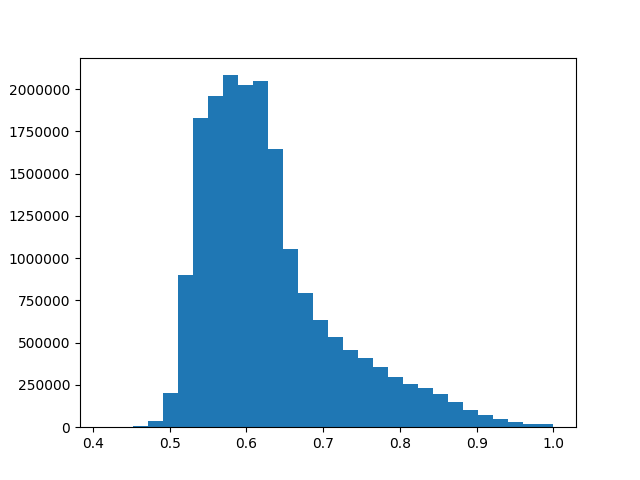

In [23]:
mols = set()
frames = []
for j, file in enumerate(files):
  frame = PandasTools.LoadSDF(file,isomericSmiles=True,
                              
                              smilesName='SMILES',molColName='Molecule', includeFingerprints=False)
  frame.replace('newline',np.nan, inplace=True)
  frames.append(frame)
frame = pd.concat(frames,ignore_index=True)
for name in names:
  pl_frame = frame.dropna(subset=[name])
  mols.update(pl_frame.Molecule.tolist())
sims = fps_similarities([FingerprintMols.FingerprintMol(x) for x in list(mols)]+
                        [FingerprintMols.FingerprintMol(x) for x in list(mols)])
plt.close()
plt.hist(sims.flatten(),bins=30)
display(plt.show())

# Vocabulary preparation

In [25]:
from iclr19_graph2graph.fast_jtnn.mol_tree import *
import rdkit
import rdkit.Chem as Chem
import copy
from iclr19_graph2graph.fast_jtnn.chemutils import get_clique_mol, tree_decomp, get_mol, get_smiles, set_atommap, enum_assemble, decode_stereo

In [26]:
import sys
lg = rdkit.RDLogger.logger() 
lg.setLevel(rdkit.RDLogger.CRITICAL)
csets = []
for name in names:
  cset = set()
  for line in open(os.path.join(G2G, 'molecules-'+name[:4]+'.txt'),'r'):
      smiles = line.split()[0]
      mol = MolTree(smiles)
      for c in mol.nodes:
        cset.add(c.smiles)
  with open(os.path.join(G2G, 'molecules-'+name[:4]+'.vocab'),'w') as outfile:
      outfile.write('\n'.join(cset))
  csets.append(cset)

# Training

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader
from torch.autograd import Variable

import math, random, sys
import numpy as np
import argparse
from collections import deque
import pickle

from iclr19_graph2graph.fast_jtnn import *
import rdkit
import csv

In [29]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [30]:
def train_vae(arglist,log_file=None):
    lg = rdkit.RDLogger.logger() 
    lg.setLevel(rdkit.RDLogger.CRITICAL)

    parser = argparse.ArgumentParser()
    parser.add_argument('--train', required=True)
    parser.add_argument('--vocab', required=True)
    parser.add_argument('--save_dir', type=str, default=None)
    parser.add_argument('--load_epoch', type=int, default=-1)

    parser.add_argument('--hidden_size', type=int, default=300)
    parser.add_argument('--batch_size', type=int, default=32)
    parser.add_argument('--rand_size', type=int, default=8)
    parser.add_argument('--depthT', type=int, default=6)
    parser.add_argument('--depthG', type=int, default=3)
    parser.add_argument('--share_embedding', action='store_true')
    parser.add_argument('--use_molatt', action='store_true')

    parser.add_argument('--clip_norm', type=float, default=50.0)
    parser.add_argument('--beta', type=float, default=1.0)
    parser.add_argument('--epoch', type=int, default=20)
    parser.add_argument('--anneal_rate', type=float, default=0.9)
    parser.add_argument('--lr', type=float, default=1e-3)

    args = parser.parse_args(arglist)
    print( args)

    vocab = [x.strip("\r\n ") for x in open(args.vocab)] 
    vocab = Vocab(vocab)

    model = DiffVAE(vocab, args).cuda()

    for param in model.parameters():
        if param.dim() == 1:
            nn.init.constant_(param, 0)
        else:
            nn.init.xavier_normal_(param)

    if args.load_epoch >= 0:
        model.load_state_dict(torch.load(args.save_dir + "/model.iter-" + str(args.load_epoch)))

    print( "Model #Params: %dK" % (sum([x.nelement() for x in model.parameters()]) / 1000,))

    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    scheduler = lr_scheduler.ExponentialLR(optimizer, args.anneal_rate)
    scheduler.step()

    PRINT_ITER = 20
    param_norm = lambda m: math.sqrt(sum([p.norm().item() ** 2 for p in m.parameters()]))
    grad_norm = lambda m: math.sqrt(sum([p.grad.norm().item() ** 2 for p in m.parameters() if p.grad is not None]))
    if log_file:
        of_connection = open(log_file, 'w')
        writer = csv.writer(of_connection)

        # Write the headers to the file
        writer.writerow(['loss', 'kl_div', 'wacc', 'tacc', 'sacc'])
    for epoch in range(args.load_epoch + 1, args.epoch):
        loader = PairTreeFolder(args.train, vocab, args.batch_size, num_workers=4)
        meters = np.zeros(4)
        print(dataset)
        for it, batch in enumerate(loader):
            x_batch, y_batch = batch
            try:
                model.zero_grad()
                loss, kl_div, wacc, tacc, sacc = model(x_batch, y_batch, args.beta)
                loss.backward()
            except Exception as e:
                print( e)
                continue

            nn.utils.clip_grad_norm_(model.parameters(), args.clip_norm)
            optimizer.step()

            meters = meters + np.array([kl_div, wacc * 100, tacc * 100, sacc * 100])
            if log_file:
                writer.writerow([loss, kl_div, wacc, tacc, sacc])
            if (it + 1) % PRINT_ITER == 0:
                meters /= PRINT_ITER
                print("KL: %.2f, Word: %.2f, Topo: %.2f, Assm: %.2f, PNorm: %.2f, GNorm: %.2f" % (meters[0], meters[1], meters[2], meters[3], param_norm(model), grad_norm(model)))
                sys.stdout.flush()
                meters *= 0

        scheduler.step()

        print( "learning rate: %.6f" % scheduler.get_lr()[0])
        if args.save_dir is not None:
            torch.save(model.state_dict(), args.save_dir + "/model.iter-" + str(epoch))
    return loss

In [31]:
train_vae(['-h'])

An exception has occurred, use %tb to see the full traceback.

 SystemExit : 0

In [32]:
# 2e training for dataset selection
datasets = ['dpEC1-all_pairs-JAK1.txt',
            'dpEC1-close_pairs-JAK1.txt',
            'dpEC1to2-all_pairs-JAK1.txt',
            'dpEC1to2-close_pairs-JAK1.txt',
            'median-all_pairs-JAK1.txt',
            'median-close_pairs-JAK1.txt',
            'pEC7.6-all_pairs-JAK1.txt',
            'pEC7.6-close_pairs-JAK1.txt']
for i,dataset in enumerate(datasets[1:]):
  save_dir = os.path.join(G2G,'models','test-2e-'+dataset[:-4]+'-hopt-2e')
  log_file = os.path.join(G2G,'models','test-2e-'+dataset[:-4]+'-hopt-2e','log.csv')
  if not os.path.exists(save_dir):
    os.mkdir(save_dir)
  input_args = ['--train',os.path.join(TENSORS,dataset[:-4]+'/')
                ,'--vocab',os.path.join(G2G, 'molecules-all_targets.vocab')
                ,'--save_dir',save_dir
                ,'--hidden_size','600'
                ,'--rand_size','22'
                ,'--epoch','2'
                ,'--anneal_rate','0.25'
                ,'--batch_size','64'
                ,'--share_embedding'
                ,'--use_molatt']
  train_vae(input_args,log_file)

Namespace(anneal_rate=0.25, batch_size=64, beta=1.0, clip_norm=50.0, depthG=3, depthT=6, epoch=2, hidden_size=600, load_epoch=-1, lr=0.001, rand_size=22, save_dir='/dbfs/FileStore/g2g/models/test-2e-dpEC1-close_pairs-JAK1', share_embedding=True, train='/dbfs/FileStore/g2g/tensors/dpEC1-close_pairs-JAK1/', use_molatt=True, vocab='/dbfs/FileStore/g2g/molecules-all_targets.vocab')
Model #Params: 12135K
dpEC1-close_pairs-JAK1.txt
KL: 0.00, Word: 18.48, Topo: 75.75, Assm: 86.13, PNorm: 127.58, GNorm: 50.00
KL: 0.00, Word: 29.17, Topo: 93.70, Assm: 93.10, PNorm: 127.84, GNorm: 28.21
KL: 0.00, Word: 46.10, Topo: 96.34, Assm: 93.71, PNorm: 128.23, GNorm: 50.00
KL: 0.00, Word: 57.08, Topo: 97.32, Assm: 93.31, PNorm: 128.59, GNorm: 46.60
KL: 0.00, Word: 66.98, Topo: 98.04, Assm: 93.82, PNorm: 128.89, GNorm: 43.05
KL: 0.00, Word: 69.73, Topo: 98.05, Assm: 94.00, PNorm: 129.13, GNorm: 50.00
KL: 0.00, Word: 71.85, Topo: 98.07, Assm: 94.21, PNorm: 129.32, GNorm: 34.51
KL: 0.00, Word: 74.14, Topo: 98.72, Assm: 94.39, PNorm: 129.52, GNorm: 29.78
KL: 0.00, Word: 75.64, Topo: 98.82, Assm: 94.58, PNorm: 129.70, GNorm: 25.61
KL: 0.00, Word: 76.16, Topo: 98.61, Assm: 94.71, PNorm: 129.87, GNorm: 26.46
KL: 0.00, Word: 77.50, Topo: 99.08, Assm: 94.72, PNorm: 130.03, GNorm: 24.27
KL: 0.00, Word: 78.17, Topo: 98.99, Assm: 95.33, PNorm: 130.18, GNorm: 26.92
KL: 0.00, Word: 78.50, Topo: 99.05, Assm: 94.77, PNorm: 130.32, GNorm: 22.89
KL: 0.00, Word: 78.76, Topo: 98.99, Assm: 95.17, PNorm: 130.46, GNorm: 50.00
KL: 0.00, Word: 79.32, Topo: 98.95, Assm: 94.92, PNorm: 130.58, GNorm: 28.95
KL: 0.00, Word: 79.15, Topo: 98.91, Assm: 94.49, PNorm: 130.71, GNorm: 31.57
KL: 0.00, Word: 79.68, Topo: 99.15, Assm: 94.80, PNorm: 130.85, GNorm: 22.39
KL: 0.00, Word: 79.90, Topo: 99.12, Assm: 95.01, PNorm: 130.98, GNorm: 20.37
KL: 0.00, Word: 80.80, Topo: 99.00, Assm: 95.38, PNorm: 131.10, GNorm: 19.20
KL: 0.00, Word: 81.02, Topo: 99.06, Assm: 94.71, PNorm: 131.23, GNorm: 30.49
KL: 0.00, Word: 80.94, Topo: 99.13, Assm: 95.71, PNorm: 131.36, GNorm: 25.91
KL: 0.00, Word: 80.57, Topo: 98.97, Assm: 95.52, PNorm: 131.47, GNorm: 20.80
KL: 0.00, Word: 80.95, Topo: 99.07, Assm: 95.49, PNorm: 131.59, GNorm: 19.20
KL: 0.00, Word: 81.28, Topo: 99.28, Assm: 95.68, PNorm: 131.70, GNorm: 20.63
KL: 0.00, Word: 81.50, Topo: 99.35, Assm: 95.72, PNorm: 131.82, GNorm: 18.85
KL: 0.00, Word: 81.80, Topo: 99.33, Assm: 95.30, PNorm: 131.92, GNorm: 18.65
KL: 0.00, Word: 81.69, Topo: 99.27, Assm: 95.21, PNorm: 132.02, GNorm: 19.54
KL: 0.00, Word: 81.66, Topo: 99.31, Assm: 95.27, PNorm: 132.12, GNorm: 16.36
KL: 0.00, Word: 82.06, Topo: 99.21, Assm: 95.43, PNorm: 132.23, GNorm: 24.30
KL: 0.00, Word: 82.37, Topo: 99.21, Assm: 95.51, PNorm: 132.33, GNorm: 18.38
KL: 0.00, Word: 82.52, Topo: 99.24, Assm: 95.71, PNorm: 132.44, GNorm: 21.40
KL: 0.00, Word: 81.98, Topo: 99.21, Assm: 95.59, PNorm: 132.55, GNorm: 18.01
KL: 0.00, Word: 82.51, Topo: 99.16, Assm: 96.07, PNorm: 132.64, GNorm: 16.47
KL: 0.00, Word: 82.16, Topo: 99.25, Assm: 95.70, PNorm: 132.74, GNorm: 18.33
KL: 0.00, Word: 82.92, Topo: 99.39, Assm: 95.52, PNorm: 132.85, GNorm: 16.87
KL: 0.00, Word: 82.21, Topo: 99.18, Assm: 96.09, PNorm: 132.95, GNorm: 17.19
KL: 0.00, Word: 82.59, Topo: 99.31, Assm: 95.55, PNorm: 133.05, GNorm: 14.85
KL: 0.00, Word: 83.13, Topo: 99.32, Assm: 96.50, PNorm: 133.14, GNorm: 13.14
KL: 0.00, Word: 82.99, Topo: 99.33, Assm: 96.15, PNorm: 133.23, GNorm: 19.39
KL: 0.00, Word: 82.87, Topo: 99.24, Assm: 96.13, PNorm: 133.33, GNorm: 21.67
KL: 0.00, Word: 83.07, Topo: 99.31, Assm: 95.78, PNorm: 133.41, GNorm: 16.17
KL: 0.00, Word: 82.34, Topo: 99.33, Assm: 95.99, PNorm: 133.50, GNorm: 22.80
KL: 0.00, Word: 83.08, Topo: 99.35, Assm: 95.69, PNorm: 133.59, GNorm: 15.14
KL: 0.00, Word: 82.72, Topo: 99.36, Assm: 96.18, PNorm: 133.68, GNorm: 24.36
KL: 0.00, Word: 83.72, Topo: 99.37, Assm: 96.25, PNorm: 133.77, GNorm: 14.54
KL: 0.00, Word: 83.64, Topo: 99.37, Assm: 96.55, PNorm: 133.86, GNorm: 20.00
KL: 0.00, Word: 83.26, Topo:

In [33]:
# Final training
datasets = [
            'dpEC1to2-close_pairs-TYK2.txt',
            'dpEC1to2-close_pairs-JAK1.txt',
]
for i,dataset in enumerate(datasets):
  save_dir = os.path.join(G2G,'models','10e-'+dataset[:-4])
  log_file = os.path.join(G2G,'models','10e-'+dataset[:-4],'log.csv')
  if not os.path.exists(save_dir):
    os.mkdir(save_dir)
  input_args = ['--train',os.path.join(TENSORS,dataset[:-4]+'/')
                ,'--vocab',os.path.join(G2G, 'molecules-all_targets.vocab')
                ,'--save_dir',save_dir
                ,'--hidden_size','600'
                ,'--rand_size','22'
                ,'--epoch','10'
                ,'--anneal_rate','0.85'
                ,'--batch_size','64'
                ,'--share_embedding'
                ,'--use_molatt']
  train_vae(input_args,log_file)

Namespace(anneal_rate=0.85, batch_size=64, beta=1.0, clip_norm=50.0, depthG=3, depthT=6, epoch=10, hidden_size=600, load_epoch=-1, lr=0.001, rand_size=22, save_dir='/dbfs/FileStore/g2g/models/10e-dpEC1to2-close_pairs-TYK2', share_embedding=True, train='/dbfs/FileStore/g2g/tensors/dpEC1to2-close_pairs-TYK2/', use_molatt=True, vocab='/dbfs/FileStore/g2g/molecules-all_targets.vocab')
Model #Params: 12135K
dpEC1to2-close_pairs-TYK2.txt
KL: 0.00, Word: 34.96, Topo: 77.48, Assm: 84.66, PNorm: 129.17, GNorm: 27.30
KL: 0.00, Word: 65.27, Topo: 95.58, Assm: 93.21, PNorm: 130.94, GNorm: 14.66
KL: 0.00, Word: 73.47, Topo: 97.80, Assm: 94.13, PNorm: 132.13, GNorm: 21.57
KL: 0.00, Word: 77.69, Topo: 98.34, Assm: 94.03, PNorm: 133.06, GNorm: 13.29
KL: 0.00, Word: 79.02, Topo: 98.54, Assm: 94.90, PNorm: 133.92, GNorm: 15.48
KL: 0.00, Word: 80.50, Topo: 98.83, Assm: 94.41, PNorm: 134.72, GNorm: 12.76
KL: 0.00, Word: 80.73, Topo: 98.81, Assm: 94.61, PNorm: 135.47, GNorm: 17.16
KL: 0.00, Word: 81.20, Topo: 99.02, Assm: 95.58, PNorm: 136.18, GNorm: 15.52
KL: 0.00, Word: 81.81, Topo: 98.75, Assm: 95.36, PNorm: 136.81, GNorm: 50.00
KL: 0.00, Word: 82.18, Topo: 98.48, Assm: 95.26, PNorm: 137.54, GNorm: 11.37
KL: 0.00, Word: 82.63, Topo: 99.05, Assm: 95.49, PNorm: 138.19, GNorm: 8.86
KL: 0.00, Word: 82.89, Topo: 99.13, Assm: 95.24, PNorm: 138.74, GNorm: 10.88
KL: 0.00, Word: 83.44, Topo: 99.19, Assm: 95.68, PNorm: 139.28, GNorm: 7.93
KL: 0.00, Word: 83.19, Topo: 99.21, Assm: 95.41, PNorm: 139.81, GNorm: 10.74
KL: 0.00, Word: 82.77, Topo: 99.23, Assm: 95.34, PNorm: 140.35, GNorm: 10.04
KL: 0.00, Word: 83.33, Topo: 99.27, Assm: 96.09, PNorm: 140.86, GNorm: 10.12
KL: 0.00, Word: 83.69, Topo: 99.19, Assm: 95.95, PNorm: 141.37, GNorm: 10.39
KL: 0.00, Word: 83.81, Topo: 99.26, Assm: 96.00, PNorm: 141.88, GNorm: 12.06
KL: 0.00, Word: 83.96, Topo: 99.23, Assm: 95.69, PNorm: 142.33, GNorm: 8.02
KL: 0.00, Word: 83.87, Topo: 99.19, Assm: 96.43, PNorm: 142.83, GNorm: 8.15
KL: 0.00, Word: 84.42, Topo: 99.23, Assm: 96.35, PNorm: 143.29, GNorm: 8.68
KL: 0.00, Word: 84.29, Topo: 99.35, Assm: 96.25, PNorm: 143.74, GNorm: 7.96
KL: 0.00, Word: 84.50, Topo: 99.37, Assm: 95.96, PNorm: 144.23, GNorm: 10.30
KL: 0.00, Word: 84.51, Topo: 99.37, Assm: 96.34, PNorm: 144.72, GNorm: 8.79
KL: 0.00, Word: 84.70, Topo: 99.32, Assm: 96.74, PNorm: 145.24, GNorm: 8.88
KL: 0.00, Word: 84.41, Topo: 99.33, Assm: 95.89, PNorm: 145.69, GNorm: 8.90
KL: 0.00, Word: 84.91, Topo: 99.36, Assm: 96.01, PNorm: 146.19, GNorm: 7.70
KL: 0.00, Word: 84.59, Topo: 99.28, Assm: 96.68, PNorm: 146.71, GNorm: 8.55
KL: 0.00, Word: 85.13, Topo: 99.37, Assm: 96.45, PNorm: 147.15, GNorm: 7.04
KL: 0.00, Word: 85.08, Topo: 99.46, Assm: 96.79, PNorm: 147.59, GNorm: 7.71
KL: 0.00, Word: 85.10, Topo: 99.36, Assm: 96.33, PNorm: 148.02, GNorm: 8.75
KL: 0.00, Word: 84.74, Topo: 99.34, Assm: 96.30, PNorm: 148.42, GNorm: 8.47
KL: 0.00, Word: 84.74, Topo: 99.41, Assm: 96.24, PNorm: 148.85, GNorm: 6.83
KL: 0.00, Word: 84.76, Topo: 99.44, Assm: 96.97, PNorm: 149.39, GNorm: 8.70
KL: 0.00, Word: 85.08, Topo: 99.39, Assm: 96.38, PNorm: 149.81, GNorm: 7.09
KL: 0.00, Word: 85.33, Topo: 99.39, Assm: 96.70, PNorm: 150.26, GNorm: 6.85
KL: 0.00, Word: 85.23, Topo: 99.36, Assm: 96.80, PNorm: 150.67, GNorm: 6.33
KL: 0.00, Word: 84.84, Topo: 99.46, Assm: 96.35, PNorm: 151.09, GNorm: 7.87
KL: 0.00, Word: 84.93, Topo: 99.37, Assm: 96.39, PNorm: 151.51, GNorm: 6.09
KL: 0.00, Word: 85.41, Topo: 99.41, Assm: 96.85, PNorm: 151.92, GNorm: 7.75
KL: 0.00, Word: 85.08, Topo: 99.39, Assm: 96.94, PNorm: 152.28, GNorm: 7.14
KL: 0.00, Word: 85.27, Topo: 99.34, Assm: 96.42, PNorm: 152.73, GNorm: 6.98
KL: 0.00, Word: 85.14, Topo: 99.40, Assm: 97.01, PNorm: 153.18, GNorm: 6.49
KL: 0.00, Word: 84.81, Topo: 99.44, Assm: 96.52, PNorm: 153.59, GNorm: 5.92
KL: 0.00, Word: 85.40, Topo: 99.39, Assm: 96.63, PNorm: 153.99, GNorm: 9.80
KL: 0.00, Word: 85.38, Topo: 99.38, Assm: 96.47, PNorm: 154.36, GNorm: 5.57
KL: 0.00, Word: 85.87, Topo: 99.48, Assm: 96.11, PN

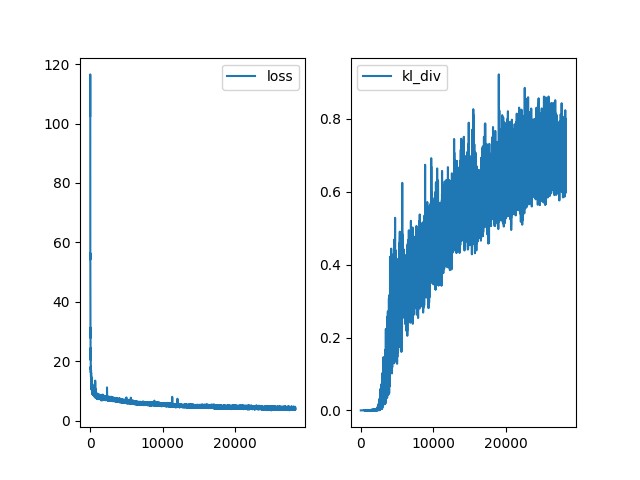

In [34]:
import re
jtnn_loss = pd.read_csv(os.path.join(G2G,'models','5e-'+'dpEC1-close_pairs-JAK1','log.csv'))
jtnn_loss['loss'] = [float(''.join(re.findall("\d+\.\d+", item))) for item in jtnn_loss['loss']]
plt.close()
plt.subplot(121)
plt.plot(jtnn_loss.loss, label = 'loss')
plt.legend()
plt.subplot(122)
plt.plot(jtnn_loss.kl_div, label = 'kl_div')
plt.legend()
display(plt.show())

# Validation

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader
from torch.autograd import Variable

import math, random, sys
import numpy as np
import argparse
from collections import deque
import pickle

from iclr19_graph2graph.fast_jtnn import *
import rdkit
import csv
import random
import copy
from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers
from rdkit.Chem.rdFMCS import FindMCS
from rdkit.Chem.AllChem import CalcNumAtomStereoCenters

In [37]:
from interruptingcow import timeout

def recover_chirality(original, translated, ringoption=True):
  if not Chem.MolFromSmiles(translated):
    return translated
  ms = [Chem.MolFromSmiles(original), 
        Chem.MolFromSmiles(translated)]
  temp = copy.deepcopy(ms)
  sumofatoms = temp[0].GetNumAtoms()+temp[1].GetNumAtoms()
  possible_isomers = list(EnumerateStereoisomers(ms[1]))
  print('isomers ',len(possible_isomers))

  if len(possible_isomers)>1:
    recovered_mols = []
    #a=0

    for c in range(10):#while sumofatoms>10:
      
      try:
        with timeout(3):
          mcs = FindMCS(temp, completeRingsOnly=False, ringMatchesRingOnly=ringoption, matchValences=True, timeout=2)
          mcs = mcs.smartsString
          #a+=1
          #print(a)
          #print(c)
          if mcs:
            mcsp = Chem.MolFromSmarts(mcs)
            match0 = temp[0].GetSubstructMatch(mcsp)
            frag0=Chem.MolFragmentToSmiles(temp[0],atomsToUse=match0,isomericSmiles=True,canonical=False)
            temp[0] = Chem.DeleteSubstructs(temp[0],Chem.MolFromSmarts(frag0))
            match1 = temp[1].GetSubstructMatch(mcsp)
            frag1=Chem.MolFragmentToSmiles(temp[1],atomsToUse=match1,isomericSmiles=True,canonical=False)
            temp[1] = Chem.DeleteSubstructs(temp[1],Chem.MolFromSmarts(frag1))
            sumofatoms = temp[0].GetNumAtoms()+temp[1].GetNumAtoms()

            if '@' in frag0:

                original_stereocenter = Chem.FindMolChiralCenters(Chem.MolFromSmiles(frag0))

            for i, mol in enumerate(possible_isomers):
              match1 = mol.GetSubstructMatch(mcsp)
              frag1=Chem.MolFragmentToSmiles(mol,atomsToUse=match1,isomericSmiles=True,canonical=False)
              if set(original_stereocenter)<=set(Chem.FindMolChiralCenters(Chem.MolFromSmiles(frag1))):
                recovered_mols.append(mol)
            possible_isomers = recovered_mols
          else:
            continue#sumofatoms = 0
      except:
        return translated
    if possible_isomers:
      return Chem.MolToSmiles(random.choice(possible_isomers))
    else:
      return translated
  else:
    return translated

In [38]:
import nonechucks as nc

def decode(arglist,outpath=None, ringoption=True):
    class Outer(RuntimeError): pass
    class Inner(RuntimeError): pass
    lg = rdkit.RDLogger.logger() 
    lg.setLevel(rdkit.RDLogger.CRITICAL)

    parser = argparse.ArgumentParser()
    parser.add_argument('--test', required=True)
    parser.add_argument('--vocab', required=True)
    parser.add_argument('--model', required=True)

    parser.add_argument('--hidden_size', type=int, default=300)
    parser.add_argument('--rand_size', type=int, default=8)
    parser.add_argument('--depthT', type=int, default=6)
    parser.add_argument('--depthG', type=int, default=3)
    parser.add_argument('--share_embedding', action='store_true')
    parser.add_argument('--use_molatt', action='store_true')

    parser.add_argument('--num_decode', type=int, default=20)
    parser.add_argument('--seed', type=int, default=1)

    args = parser.parse_args(arglist)

    vocab = [x.strip("\r\n ") for x in open(args.vocab)] 
    vocab = Vocab(vocab)

    model = DiffVAE(vocab, args).cuda()
    model.load_state_dict(torch.load(args.model))

    with open(args.test) as f:
        datatext = [line.split()[0] for line in f]

    data = [MolTree(s) for s in datatext]
    batches = [data[i : i + 1] for i in range(0, len(data))]
    dataset = MolTreeDataset(batches, vocab, assm=False)
    #loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0, collate_fn=lambda x:x[0])
    dataset = nc.SafeDataset(dataset)
    loader = nc.SafeDataLoader(dataset,batch_size=1,num_workers=0, shuffle=False, collate_fn=lambda x:x[0])
    torch.manual_seed(args.seed)
    outlist = []
    for i, batch in enumerate(loader):
        mol_batch = batch[0]
        x_tree_vecs, _, x_mol_vecs = model.encode(batch[1], batch[2])
        assert x_tree_vecs.size(0) == x_mol_vecs.size(0)

        for k in range(args.num_decode):
            z_tree_vecs, z_mol_vecs = model.fuse_noise(x_tree_vecs, x_mol_vecs)
            smiles = mol_batch[0].smiles
            print(smiles, i)
            #
            
            try:
              with timeout(3, Outer):
                try:
                  new_smiles = model.decode(z_tree_vecs[0].unsqueeze(0), z_mol_vecs[0].unsqueeze(0))
                except:
                  new_smiles = None
            except Outer:
              new_smiles = None
              pass
            if new_smiles is None:
                #
                new_smiles = 'c'
            
            try:
              with timeout(10, Inner):
                new_smiles = recover_chirality(smiles,new_smiles,ringoption)
            except:
              pass
            print(datatext[i], new_smiles)
            outlist.append((smiles,new_smiles))
    if outpath:
        with open(outpath,'w') as outfile:
          for pair in outlist:
            try:
              outfile.write(' '.join(list(pair))+'\n')
            except:
              continue
    return set(outlist)

In [39]:
def parallel_decode(dataset):
  loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0, collate_fn=lambda x:x[0])

  torch.manual_seed(args.seed)
  outlist = []
  for i, batch in enumerate(loader):
      mol_batch = batch[0]
      x_tree_vecs, _, x_mol_vecs = model.encode(batch[1], batch[2])
      assert x_tree_vecs.size(0) == x_mol_vecs.size(0)

      for k in range(args.num_decode):
          z_tree_vecs, z_mol_vecs = model.fuse_noise(x_tree_vecs, x_mol_vecs)
          smiles = mol_batch[0].smiles
          print(smiles, i)
          #
          class Outer(RuntimeError): pass
          try:
            with timeout(3):
              try:
                new_smiles = model.decode(z_tree_vecs[0].unsqueeze(0), z_mol_vecs[0].unsqueeze(0))
              except:
                new_smiles = None
          except Outer:
            new_smiles = None
          if new_smiles is None:
              #
              new_smiles = 'c'
          new_smiles = recover_chirality(smiles,new_smiles,ringoption)
          print(datatext[i], new_smiles)
          outlist.append((smiles,new_smiles))
  return outlist

In [40]:
def activity_score(generated_pairs,folder,translated_preds=None, original = True):
  if not os.path.exists(folder):
    os.mkdir(folder)
  generated_pairs = pd.DataFrame(generated_pairs).rename(columns={0:'SMILES',1:'smiles'})
  print(generated_pairs.head())
  from chemprop.parsing import parse_predict_args
  from chemprop.train import make_predictions
  from chemprop.parsing import add_predict_args
  from chemprop.parsing import modify_predict_args
  checkpoint_path = os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-2188-sparse-regression-scaffold')#os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-1825-regression')#'hyperopt_4x','fold_0/model_0/model.pt')#os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-bin76_ext','fold_0/model_0/model.pt')
  translated_path = os.path.join(folder,'translated.smi')
  
  if not translated_preds:
    translated_preds = os.path.join(folder,'translated.csv')
  generated_pairs.filter(['smiles']).to_csv(translated_path,index=False)
#   with open(given_path,'w') as given:
#     given.write('\n'.join([pair[0] for pair in generated_pairs]))
#   with open(translated_path,'w') as translated:
#     for pair in generated_pairs:
#       try:
#         translated.write(pair[1]+'\n')
#       except:
#         translated.write('None')

  pred_parser = ArgumentParser()
  add_predict_args(pred_parser)
  args = pred_parser.parse_args(['--test_path',translated_path,
                                 #'--checkpoint_path',checkpoint_path,
                                 '--checkpoint_dir',checkpoint_path,
                                 '--preds_path',translated_preds
                                ])
  modify_predict_args(args)
  make_predictions(args)
  if original:
    given_preds = pd.read_csv(os.path.join(G2G, 'validation_set-all_targets.csv'))#given_preds = pd.read_csv(given_preds) # TAKE REAL NUMBERS!!!
    given_preds = generated_pairs.merge(given_preds,on='SMILES')
  else:
    given_path = os.path.join(folder,'given.smi')
    given_preds = os.path.join(folder,'given.csv')
    generated_pairs.filter(['SMILES']).to_csv(given_path,index=False) #########MIGHT WANT TO RENAME TO smiles
    args = pred_parser.parse_args(['--test_path',given_path,
                                 #'--checkpoint_path',checkpoint_path,
                                 '--checkpoint_dir',checkpoint_path,
                                 '--preds_path',given_preds
                                ])
    modify_predict_args(args)
    make_predictions(args)
    given_preds = pd.read_csv(given_preds)#########MIGHT WANT TO RENAME TO SMILES

  #given_preds = translated_preds.merge(given_preds,on='smiles',how='left')
  translated_preds = pd.read_csv(translated_preds)
  
  print(given_preds.head())
  print(translated_preds.head())
  xsmiles = given_preds.SMILES.tolist()
  ysmiles = translated_preds.smiles.tolist()
  print(len(given_preds))
  print(len(translated_preds))
  diff = translated_preds[targets[0]]-given_preds[targets[0]]#names[0]]-given_preds[targets[0]]
  #print(given_preds[targets[0]])
  #print(translated_preds[targets[0]])
  #print(diff)
  print(np.mean(diff))
  return [(x, y, 
           similarity(x,y), 
           z, q) for x, y, z, q in zip(xsmiles,ysmiles,diff,given_preds[targets[0]])] #check if similarity is 0 - then the generated molecule is bad



In [41]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
def similarity(a, b):
    if a is None or b is None: 
        return 0.0
    amol = Chem.MolFromSmiles(a)
    #if b is 
    bmol = Chem.MolFromSmiles(b)
    
    if amol is None or bmol is None:
        return 0.0

    fp1 = AllChem.GetMorganFingerprintAsBitVect(amol, 2, nBits=2048, useChirality=False)
    fp2 = AllChem.GetMorganFingerprintAsBitVect(bmol, 2, nBits=2048, useChirality=False)
    return DataStructs.TanimotoSimilarity(fp1, fp2) 
# We define the diversity of a set of molecules as the average pairwise Tanimoto distance
# between them, where Tanimoto distance dist(X; Y ) = 1 - sim(X; Y ). For each source molecule,
# we translate it K times (each with different latent codes), and compute the diversity over the set of
# validly translated molecules.2 As we require valid translated molecules to be similar to a given compound,
# the diversity score is upper-bounded by the maximum allowed distance (e.g. the maximum
# diversity score is around 0.6 on the QED and DRD2 tasks). As shown in Tables 1 and 2, our methods
# achieve higher diversity score than MMPA and VSeq2Seq on two and three tasks respectively.
# Figure 4 shows some examples of diverse translation over the QED and DRD2 tasks
from itertools import groupby

def diversity(data):
    all_div = []
    n_succ = 0
    blocks = [list(grp) for k, grp in groupby(data, lambda x: x[0])]
    for block in blocks:#i in range(0, len(data), args.num_decode):
        #set_x = set([x[0] for x in data[i:i+args.num_decode]])
        #assert len(set_x) == 1

        good = [y for x,y,sim,prop in block if sim >= 0.3 and prop >= 0.5]
        if len(good) == 0:
            continue

        good = list(set(good))
        if len(good) == 1:
            all_div.append(0.0)
            continue
        n_succ += 1

        div = 0.0
        tot = 0
        for i in range(len(good)):
            for j in range(i + 1, len(good)):
                div += 1 - similarity(good[i], good[j])
                tot += 1
        div /= tot
        all_div.append(div)

    all_div = np.array(all_div)
    return np.mean(all_div), np.std(all_div), n_succ

In [42]:
def novelty(generated_pairs, training_pairs):

  generated_set = set([Chem.MolToSmiles(Chem.MolFromSmiles(pair[1]),isomericSmiles=False,canonical=True) for pair in generated_pairs if Chem.MolFromSmiles(pair[1])])
  training_set = set([Chem.MolToSmiles(Chem.MolFromSmiles(pair[1]),isomericSmiles=False,canonical=True) for pair in training_pairs if Chem.MolFromSmiles(pair[1])])#list(sum(training_pairs, ()))

  return 1-len(generated_set&training_set)/len(generated_set)
#Let M be the set of molecules generated by the model and S be the
#molecules given during training. We define novelty as 1 - |M&S|/|S|. # LETS DO IT WITH /|M| INSTEAD TO ACCOUNT FOR DIVERSITY

In [43]:
# Example of validation using share_embedding = False option
valid_file = os.path.join(G2G, 'validation_set-all_targets.smi')
datasets = [#'dpEC1-all_pairs-JAK1.txt',
            'dpEC1-close_pairs-JAK1.txt',
#             'dpEC1to2-all_pairs-JAK1.txt',
            'dpEC1to2-close_pairs-JAK1.txt'#,
#             'median-all_pairs-JAK1.txt',
#             'median-close_pairs-JAK1.txt',
#             'pEC7.6-all_pairs-JAK1.txt',
#             'pEC7.6-close_pairs-JAK1.txt'
           ]
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
res = []
for j,dataset in enumerate(datasets):
  for i in range(5):

    outpath = os.path.join(G2G,'models','5e-share-embedding_F'+dataset[:-4],'iter'+str(i)+'validation_decoded-pairs.txt')
    arglist=['--test',valid_file
            ,'--vocab',os.path.join(G2G, 'molecules-all_targets.vocab')
            ,'--model',os.path.join(G2G,'models','5e-share-embedding_F'+dataset[:-4],'model.iter-'+str(i))
            ,'--hidden_size','600'
            ,'--rand_size','22'
            #,'--share_embedding'
            ,'--use_molatt'
            ,'--num_decode','10'
            ]
    outlist = list(decode(arglist,outpath))
for j,dataset in enumerate(datasets):
  for i in range(5):
    outlist = [line.strip().split(' ') for line in open(os.path.join(G2G,'models','5e-share-embedding_F'+dataset[:-4],'iter'+str(i)+'validation_decoded-pairs.txt'))]
    activity_score_l = activity_score(outlist,os.path.join(G2G,'models','5e-share-embedding_F'+dataset[:-4]))
    property_increase = np.array([prop for x,y,sim,prop,q in activity_score_l])
    sims_mean = np.mean([sim for x,y,sim,prop,q in activity_score_l])
    sims_std = np.std([sim for x,y,sim,prop,q in activity_score_l])
    print(property_increase)
    avg_prop = np.nanmean(property_increase)
    print(avg_prop)
    std_prop = np.nanstd(property_increase)
    mean_div, std_div, n_succ = diversity([(x,y,sim,prop) for x,y,sim,prop,q in activity_score_l])
    train_pair = [line.strip().split() for line in open(os.path.join(G2G,training_pairs[j]),'r')]
    avg_novelty = novelty(list(outlist), train_pair)
    res.append((avg_prop,std_prop,mean_div, std_div, n_succ,avg_novelty,sims_mean,sims_std))
import pickle
pickle.dump(res,open(os.path.join(G2G,'5e-share-embedding_F-validation-chiral-s03p05-all_iters.p'),'wb'))

N#CCCC(=O)N1CC[C@@H](OC(=O)N2C3CCC2CN(c2ncnc4[nH]ccc24)C3)C1 0
isomers 2
N#CCCC(=O)N1CC[C@@H](OC(=O)N2C3CCC2CN(c2ncnc4[nH]ccc24)C3)C1 CN(C[C@@H]1CCCN1C(=O)CC#N)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
N#CCCC(=O)N1CC[C@@H](OC(=O)N2C3CCC2CN(c2ncnc4[nH]ccc24)C3)C1 0
isomers 2
N#CCCC(=O)N1CC[C@@H](OC(=O)N2C3CCC2CN(c2ncnc4[nH]ccc24)C3)C1 CN(C[C@@H]1CC(F)(F)CN1C(=O)CC#N)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
N#CCCC(=O)N1CC[C@@H](OC(=O)N2C3CCC2CN(c2ncnc4[nH]ccc24)C3)C1 0
isomers 2
N#CCCC(=O)N1CC[C@@H](OC(=O)N2C3CCC2CN(c2ncnc4[nH]ccc24)C3)C1 CN(C[C@@H]1CC(F)(F)CN1C(=O)CC#N)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
N#CCCC(=O)N1CC[C@@H](OC(=O)N2C3CCC2CN(c2ncnc4[nH]ccc24)C3)C1 0
isomers 1
N#CCCC(=O)N1CC[C@@H](OC(=O)N2C3CCC2CN(c2ncnc4[nH]ccc24)C3)C1 O=C(c1ccc(S(=O)(=O)NCc2cccs2)cc1)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
N#CCCC(=O)N1CC[C@@H](OC(=O)N2C3CCC2CN(c2ncnc4[nH]ccc24)C3)C1 0
isomers 1
N#CCCC(=O)N1CC[C@@H](OC(=O)N2C3CCC2CN(c2ncnc4[nH]ccc24)C3)C1 O=C(c1ccc(S(=O)(=O)NCc2cccs2)cc1)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
N#CCCC(=O)N1CC[C@@H](OC(=O)N2C3CCC2CN(c2ncnc4[nH]ccc24)C3)C1 0
isomers 2
N#CCCC(=O)N1CC[C@@H](OC(=O)N2C3CCC2CN(c2ncnc4[nH]ccc24)C3)C1 CN(C[C@H]1CC(F)(F)CN1C(=O)CC#N)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
N#CCCC(=O)N1CC[C@@H](OC(=O)N2C3CCC2CN(c2ncnc4[nH]ccc24)C3)C1 0
isomers 1
N#CCCC(=O)N1CC[C@@H](OC(=O)N2C3CCC2CN(c2ncnc4[nH]ccc24)C3)C1 O=C(c1ccc(S(=O)(=O)NCc2cccs2)cc1)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
N#CCCC(=O)N1CC[C@@H](OC(=O)N2C3CCC2CN(c2ncnc4[nH]ccc24)C3)C1 0
isomers 2
N#CCCC(=O)N1CC[C@@H](OC(=O)N2C3CCC2CN(c2ncnc4[nH]ccc24)C3)C1 CN(C[C@@H]1CC(F)(F)CN1C(=O)CC#N)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
N#CCCC(=O)N1CC[C@@H](OC(=O)N2C3CCC2CN(c2ncnc4[nH]ccc24)C3)C1 0
isomers 1
N#CCCC(=O)N1CC[C@@H](OC(=O)N2C3CCC2CN(c2ncnc4[nH]ccc24)C3)C1 O=C(c1ccc(S(=O)(=O)NCc2cccs2)cc1)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
N#CCCC(=O)N1CC[C@@H](OC(=O)N2C3CCC2CN(c2ncnc4[nH]ccc24)C3)C1 0
isomers 2
N#CCCC(=O)N1CC[C@@H](OC(=O)N2C3CCC2CN(c2ncnc4[nH]ccc24)C3)C1 CN(C[C@@H]1CC(F)(F)CN1C(=O)CC#N)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
CN(C[C@H]1CC(F)(F)CN1C(=O)CCC(=O)O)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2 1
isomers 2
CN(C[C@H]1CC(F)(F)CN1C(=O)CCC(=O)O)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2 CN(C[C@H]1CC(F)(F)CN1C(=O)CC#N)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
CN(C[C@H]1CC(F)(F)CN1C(=O)CCC(=O)O)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2 1
isomers 2
CN(C[C@H]1CC(F)(F)CN1C(=O)CCC(=O)O)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2 CN(C[C@H]1CC(F)(F)CN1C(=O)Cc1nnn[nH]1)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
CN(C[C@H]1CC(F)(F)CN1C(=O)CCC(=O)O)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2 1
isomers 2
CN(C[C@H]1CC(F)(F)CN1C(=O)CCC(=O)O)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2 CN(C[C@H]1CC(F)(F)CN1C(=O)Cc1nnn[nH]1)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
CN(C[C@H]1CC(F)(F)CN1C(=O)CCC(=O)O)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2 1
isomers 2
CN(C[C@H]1CC(F)(F)CN1C(=O)CCC(=O)O)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2 CN(C[C@H]1CC(F)(F)CN1C(=O)Cc1nnn[nH]1)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
CN(C[C@H]1CC(F)(F)CN1C(=O)CCC(=O)O)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2 1
isomers 2
CN(C[C@H]1CC(F)(F)CN1C(=O)CCC(=O)O)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2 CN(C[C@H]1CC(F)(F)CN1C(=O)Cc1nnn[nH]1)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
CN(C[C@H]1CC(F)(F)CN1C(=O)CCC(=O)O)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2 1
isomers 2
CN(C[C@H]1CC(F)(F)CN1C(=O)CCC(=O)O)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2 CN(C[C@H]1CC(F)(F)CN1C(=O)Cc1nnn[nH]1)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
CN(C[C@H]1CC(F)(F)CN1C(=O)CCC(=O)O)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2 1
isomers 2
CN(C[C@H]1CC(F)(F)CN1C(=O)CCC(=O)O)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2 CN(C[C@H]1CC(F)(F)CN1C(=O)Cc1nnn[nH]1)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
CN(C[C@H]1CC(F)(F)CN1C(=O)CCC(=O)O)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2 1
isomers 2
CN(C[C@H]1CC(F)(F)CN1C(=O)CCC(=O)O)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2 CN(C[C@H]1CC(F)(F)CN1C(=O)Cc1nnn[nH]1)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
CN(C[C@H]1CC(F)(F)CN1C(=O)CCC(=O)O)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23

In [44]:
# Validation of the last models
valid_file = os.path.join(G2G, 'validation_set-all_targets.smi')
datasets = [#'dpEC1-all_pairs-JAK1.txt',
            'dpEC1to2-close_pairs-JAK1.txt',
            'dpEC1to2-close_pairs-TYK2.txt'
#             'dpEC1to2-all_pairs-JAK1.txt',
#            'dpEC1to2-close_pairs-JAK1.txt'#,
#             'median-all_pairs-JAK1.txt',
#             'median-close_pairs-JAK1.txt',
#             'pEC7.6-all_pairs-JAK1.txt',
#             'pEC7.6-close_pairs-JAK1.txt'
           ]
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
res = []
#training_pairs = ['dpEC1to2-close_pairs-JAK1.txt','dpEC1to2-close_pairs-JAK2.txt','dpEC1to2-close_pairs-JAK3.txt','dpEC1to2-close_pairs-TYK2.txt']
training_pairs = datasets#['dpEC1-all_pairs-JAK1.txt','dpEC1-all_pairs-JAK1.txt']
for j,dataset in enumerate(datasets):
  if not os.path.exists(os.path.join(G2G,'models','10e-chiral-'+dataset[:-4])):
    os.mkdir(os.path.join(G2G,'models','10e-chiral-'+dataset[:-4]))
  for i in [9]:
    #os.path.join(G2G,'models','10e-'+dataset[:-4])
    outpath = os.path.join(G2G,'models','10e-chiral-'+dataset[:-4],'iter'+str(i)+'validation_decoded-pairs.txt')
    arglist=['--test',valid_file
            ,'--vocab',os.path.join(G2G, 'molecules-all_targets.vocab')
            ,'--model',os.path.join(G2G,'models','10e-'+dataset[:-4],'model.iter-'+str(i))
            ,'--hidden_size','600'
            ,'--rand_size','22'
            ,'--share_embedding'
            ,'--use_molatt'
            ,'--num_decode','10'
            ]
    outlist = list(decode(arglist,outpath))
for j,dataset in enumerate(datasets):
  for i in [9]:#in range(5)
    outlist = [line.strip().split(' ') for line in open(os.path.join(G2G,'models','10e-chiral-'+dataset[:-4],'iter'+str(i)+'validation_decoded-pairs.txt'))]
    activity_score_l = activity_score(outlist,os.path.join(G2G,'models','10e-chiral-'+dataset[:-4]))
    property_increase = np.array([prop for x,y,sim,prop,q in activity_score_l])
    sims_mean = np.mean([sim for x,y,sim,prop,q in activity_score_l])
    sims_std = np.std([sim for x,y,sim,prop,q in activity_score_l])
    print(property_increase)
    avg_prop = np.nanmean(property_increase)
    print(avg_prop)
    std_prop = np.nanstd(property_increase)
    mean_div, std_div, n_succ = diversity([(x,y,sim,prop) for x,y,sim,prop,q in activity_score_l])
    train_pair = [line.strip().split() for line in open(os.path.join(G2G,training_pairs[j]),'r')]
    avg_novelty = novelty(list(outlist), train_pair)
    res.append((avg_prop,std_prop,mean_div, std_div, n_succ,avg_novelty,sims_mean,sims_std))
import pickle
pickle.dump(res,open(os.path.join(G2G,'10e-validation-chiral-s03p05-iter9-JAK1TYK2.p'),'wb'))

In [45]:
for j,dataset in enumerate(datasets):
  for i in [9]:#in range(5)
    outlist = [line.strip().split(' ') for line in open(os.path.join(G2G,'models','10e-chiral-'+dataset[:-4],'iter'+str(i)+'validation_decoded-pairs.txt'))]
    activity_score_l = activity_score(outlist,os.path.join(G2G,'models','10e-chiral-'+dataset[:-4]))#[:-4]
    property_increase = np.array([prop for x,y,sim,prop,q in activity_score_l])
    sims_mean = np.mean([sim for x,y,sim,prop,q in activity_score_l])
    sims_std = np.std([sim for x,y,sim,prop,q in activity_score_l])
    print(property_increase)
    avg_prop = np.nanmean(property_increase)
    print(avg_prop)
    std_prop = np.nanstd(property_increase)
    mean_div, std_div, n_succ = diversity([(x,y,sim,prop) for x,y,sim,prop,q in activity_score_l])
    train_pair = [line.strip().split() for line in open(os.path.join(G2G,training_pairs[j]),'r')]#dataset
    avg_novelty = novelty(list(outlist), train_pair)
    res.append((avg_prop,std_prop,mean_div, std_div, n_succ,avg_novelty,sims_mean,sims_std))
import pickle
pickle.dump(res,open(os.path.join(G2G,'10e-validation-chiral-s03p05-iter9-JAK1TYK2.p'),'wb'))

SMILES smiles
0 N#CCCC(=O)N1CC[C@@H](OC(=O)N2C3CCC2CN(c2ncnc4[... N#C[C@@H]1C[C@]23CC[C@]24[C@@H]2[C@@H]5CC[C@H]...
1 N#CCCC(=O)N1CC[C@@H](OC(=O)N2C3CCC2CN(c2ncnc4[... N#CC1CC(OC(=O)N2C3CCC2CN(c2ncnc4[nH]ccc24)C3)C1
2 N#CCCC(=O)N1CC[C@@H](OC(=O)N2C3CCC2CN(c2ncnc4[... O=C(OCC1CCCN1C(=O)CO)C1CCN(c2ncnc3[nH]ccc23)CC...
3 N#CCCC(=O)N1CC[C@@H](OC(=O)N2C3CCC2CN(c2ncnc4[... CCOC(=O)C(=O)N1CCCC1CN(C)S(=O)(=O)N1CCN(c2ncnc...
4 N#CCCC(=O)N1CC[C@@H](OC(=O)N2C3CCC2CN(c2ncnc4[... CS(=O)(=O)N1CC(F)(F)C[C@@H]1COC(=O)N1CCCN(c2nc...
Loading training args
Loading data
 0%| | 0/1820 [00:00<?, ?it/s] 12%|█▏ | 222/1820 [00:00<00:00, 2213.53it/s] 27%|██▋ | 485/1820 [00:00<00:00, 2322.51it/s] 38%|███▊ | 688/1820 [00:00<00:00, 2224.21it/s] 49%|████▉ | 899/1820 [00:00<00:00, 2185.33it/s] 62%|██████▏ | 1130/1820 [00:00<00:00, 2220.71it/s] 76%|███████▋ | 1389/1820 [00:00<00:00, 2318.12it/s] 89%|████████▉ | 1624/1820 [00:00<00:00, 2327.45it/s]100%|██████████| 1820/1820 [00:00<00:00, 2333.06it/s]
Validating SMILES
Test size = 1,818
Predicting with an ensemble of 5 models
 0%| | 0/5 [00:00<?, ?it/s]Loading pretrained parameter "encoder.encoder.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.W_i.weight".
Loading pretrained parameter "encoder.encoder.W_h.weight".
Loading pretrained parameter "encoder.encoder.W_o.weight".
Loading pretrained parameter "encoder.encoder.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".
Moving model to cuda

 0%| | 0/37 [00:00<?, ?it/s]
 8%|▊ | 3/37 [00:00<00:01, 24.80it/s]
 16%|█▌ | 6/37 [00:00<00:01, 24.47it/s]
 24%|██▍ | 9/37 [00:00<00:01, 24.09it/s]
 32%|███▏ | 12/37 [00:00<00:01, 24.44it/s]
 41%|████ | 15/37 [00:00<00:00, 24.10it/s]
 49%|████▊ | 18/37 [00:00<00:00, 23.90it/s]
 57%|█████▋ | 21/37 [00:00<00:00, 24.88it/s]
 65%|██████▍ | 24/37 [00:00<00:00, 24.87it/s]
 73%|███████▎ | 27/37 [00:01<00:00, 24.69it/s]
 81%|████████ | 30/37 [00:01<00:00, 25.33it/s]
 89%|████████▉ | 33/37 [00:01<00:00, 24.97it/s]
 97%|█████████▋| 36/37 [00:01<00:00, 24.28it/s]
100%|██████████| 37/37 [00:01<00:00, 24.95it/s] 20%|██ | 1/5 [00:03<00:14, 3.74s/it]Loading pretrained parameter "encoder.encoder.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.W_i.weight".
Loading pretrained parameter "encoder.encoder.W_h.weight".
Loading pretrained parameter "encoder.encoder.W_o.weight".
Loading pretrained parameter "encoder.encoder.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".
Moving model to cuda

 0%| | 0/37 [00:00<?, ?it/s]
 8%|▊ | 3/37 [00:00<00:01, 22.48it/s]
 16%|█▌ | 6/37 [00:00<00:01, 23.61it/s]
 24%|██▍ | 9/37 [00:00<00:01, 23.47it/s]
 32%|███▏ | 12/37 [00:00<00:01, 23.50it/s]
 43%|████▎ | 16/37 [00:00<00:00, 24.61it/s]
 51%|█████▏ | 19/37 [00:00<00:00, 24.86it/s]
 59%|█████▉ | 22/37 [00:00<00:00, 23.68it/s]
 68%|██████▊ | 25/37 [00:01<00:00, 24.72it/s]
 76%|███████▌ | 28/37 [00:01<00:00, 25.56it/s]
 84%|████████▍ | 31/37 [00:01<00:00, 24.85it/s]
 95%|█████████▍| 35/37 [00:01<00:00, 25.59it/s]
100%|██████████| 37/37 [00:01<00:00, 25.43it/s] 40%|████ | 2/5 [00:07<00:11, 3.81s/it]Loading pretrained parameter "encoder.encoder.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.W_i.weight".
Loading pretrained parameter "encoder.encoder.W_h.weight".
Loading pretrained parameter "encoder.encoder.W_o.weight".
Loading pretrained parameter "encoder.encoder.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".
Moving model to cuda

 0%| | 0/37 [00:00<?, ?it/s]
 8%|▊ | 3/37 [00:00<00:01, 25.73it/s]
 16%|█▌ | 6/37 [00:00<00:01, 24.80it/s]
 24%|██▍ | 9/37 [00:00<0

In [46]:
res = pickle.load(open(os.path.join(G2G,'10e-validation-chiral-s03p05-iter9-JAK1TYK2.p'),'rb'))
results = pd.DataFrame(list(res))
results.columns = ['avg_prop','std_prop','mean_div', 'std_div', 'n_succ','avg_novelty','sims_mean','sims_std']
display(results)

avg_prop,std_prop,mean_div,std_div,n_succ,avg_novelty,sims_mean,sims_std
0.760551624021238,0.9435590766834762,0.4712098177545882,0.13883193464732685,143,NaN,0.48786689184714643,0.13445256270042835
0.7073940272725928,0.9816754884829899,0.44452234398229257,0.16190663042834316,131,NaN,0.4665141018336618,0.14664937101799475
0.760551624021238,0.9435590766834762,0.4712098177545882,0.13883193464732685,143,NaN,0.48786689184714643,0.13445256270042835
0.7073940272725928,0.9816754884829899,0.44452234398229257,0.16190663042834316,131,NaN,0.4665141018336618,0.14664937101799475
0.760551624021238,0.9435590766834762,0.4712098177545882,0.13883193464732685,143,0.10606060606060608,0.48786689184714643,0.13445256270042835
0.7073940272725928,0.9816754884829899,0.44452234398229257,0.16190663042834316,131,0.08775137111517373,0.4665141018336618,0.14664937101799475


In [47]:
res = pickle.load(open(os.path.join(G2G,'5e-share-embedding_F-validation-s03p05-all_iters.p'),'rb'))
results = pd.DataFrame(list(res))
results.columns = ['avg_prop','std_prop','mean_div', 'std_div', 'n_succ','avg_novelty','sims_mean','sims_std']
display(results)

avg_prop,std_prop,mean_div,std_div,n_succ,avg_novelty,sims_mean,sims_std
1.2618098745230155,0.8974976751887569,0.16018720926536553,0.21407977831503638,59,0.9882005899705015,0.4497867268843131,0.1255024872611416
0.9997467451922056,0.886988778347672,0.42853283841649115,0.16702511208005072,134,0.9669616519174041,0.4689838976670579,0.13463888367034657
1.0282540901171533,0.942453285208394,0.42175669232964125,0.15224944871477278,144,0.9474926253687316,0.47455927898862726,0.13507806809057946
1.0382944840762325,0.948263104905585,0.44869146647100916,0.15972443143777332,144,0.9286135693215339,0.4778494361615607,0.12950641547264755
1.0189111427701076,0.9569724891516707,0.4488408772261535,0.1631457592063764,146,0.9156342182890855,0.4728283406011357,0.13016353717874735
0.95078601855745,0.8276476261571076,0.20122690617135214,0.19409279384428316,83,0.9876106194690265,0.4553401239698677,0.11993301743382051
0.8769459563276296,0.8543852785716859,0.393134558786869,0.19151609319947785,127,0.9581120943952802,0.467775907782868,0.1269870993404943
0.9622259994140232,0.8270840825377306,0.42347390122885403,0.15935112955278916,137,0.9421828908554573,0.48530690657706776,0.1387924979211857
0.9330467688067331,0.8327951869426475,0.44572871292674543,0.1473230535219091,140,0.9056047197640118,0.4856413643073152,0.13541212818140158
0.8702570764886675,0.8152217187856616,0.4498513364647479,0.1410978596020753,142,0.8737463126843658,0.5010721738749494,0.1371409606934238


In [48]:
res = pickle.load(open(os.path.join(G2G,'5e-share-embedding_F-validation-chiral-s03p05-all_iters.p'),'rb'))
results = pd.DataFrame(list(res))
results.columns = ['avg_prop','std_prop','mean_div', 'std_div', 'n_succ','avg_novelty','sims_mean','sims_std']
display(results)

avg_prop,std_prop,mean_div,std_div,n_succ,avg_novelty,sims_mean,sims_std
1.3811533295054552,0.8923157210006002,0.13270402515156332,0.18450834584473563,115,0.9805309734513274,0.4497867268843131,0.1255024872611416
1.045092219889807,0.9110223836889695,0.3998568986149555,0.15841279729132024,142,0.9551622418879055,0.4689838976670579,0.13463888367034657
1.0762722919597838,0.9674493619110462,0.39910049125246705,0.1562069134214145,147,0.91976401179941,0.47455927898862726,0.13507806809057946
1.069387558049327,0.963332826916005,0.42851800396327944,0.15978557025767448,148,0.8991150442477877,0.4778494361615607,0.12950641547264755
1.0390402027323495,0.9821793900317191,0.44022207614486303,0.15645668745844157,154,0.8861356932153392,0.4728283406011357,0.13016353717874735
1.0674448603203925,0.82052445091812,0.15820823692091937,0.1638549264075541,112,0.976401179941003,0.4553401239698677,0.11993301743382051
0.9267740901603332,0.880789292217055,0.34184068563501613,0.17431370813219446,135,0.9504424778761063,0.467775907782868,0.1269870993404943
1.0150834188125544,0.856579096789476,0.4063063496448492,0.14439537111328615,146,0.9162241887905604,0.48530690657706776,0.1387924979211857
0.9668437275195868,0.8603174441828523,0.4278229666327496,0.14802508138858314,148,0.8820058997050148,0.4856413643073152,0.13541212818140158
0.8980572937468597,0.8389436125434427,0.43475420371010876,0.14882517441452547,147,0.8448377581120944,0.5010721738749494,0.1371409606934238


In [49]:
res = pickle.load(open(os.path.join(G2G,'5e-validation-s03p05-all_iters.p'),'rb'))
results = pd.DataFrame(list(res))
results.columns = ['avg_prop','std_prop','mean_div', 'std_div', 'n_succ','avg_novelty','sims_mean','sims_std']
display(results)

avg_prop,std_prop,mean_div,std_div,n_succ,avg_novelty,sims_mean,sims_std
1.049008052354652,0.9463361026581765,0.4190554740873091,0.17170978893432198,138,0.9811209439528024,0.49205141986761425,0.1362791531277407
0.7692376099635817,1.1614070458532197,0.4631593010556476,0.14430605624298956,142,0.9421828908554573,0.4702857626883,0.14092096150597466
0.9262714631022846,0.9886232126095879,0.46029115101291945,0.14224617865694927,143,0.9050147492625369,0.48302093547471947,0.13290127674330185
0.8991414702555026,1.0123308011300105,0.4623812113444051,0.1425838571980792,145,0.8855457227138643,0.48715670929616073,0.13429744927717738
0.8735164020667611,0.998460555342624,0.48226007400967524,0.12328374404458126,146,0.871976401179941,0.48333539181091945,0.13425367364956625
0.8986491954274987,1.0097080893805752,0.18174439280987245,0.238688635355199,47,0.9952802359882006,0.4577440524764436,0.12190320018031858
0.8869823761372613,0.8699674588659538,0.4120279382259372,0.1871554818449691,129,0.9551622418879055,0.49476186508376546,0.1322664634625932
0.8359369973911841,0.8280012890887117,0.4461442081960891,0.15624777767381035,138,0.8985250737463126,0.49136538402778274,0.13550989480105588
0.8804971181378141,0.796470835327833,0.44980832967811313,0.15413254773966747,141,0.8861356932153392,0.49761446647819135,0.14470481752157222
0.859916810539326,0.8368701377513291,0.4434246222585257,0.1526636436767625,141,0.8525073746312685,0.49854221142828103,0.1438018318765882


In [50]:
res = pickle.load(open(os.path.join(G2G,'5e-share-embedding_F-validation-chiral-s03p05-all_iters.p'),'rb'))
results = pd.DataFrame(list(res))
results.columns = ['avg_prop','std_prop','mean_div', 'std_div', 'n_succ','avg_novelty','sims_mean','sims_std']
display(results)

avg_prop,std_prop,mean_div,std_div,n_succ,avg_novelty,sims_mean,sims_std
1.087695621853388,0.9159867644354913,0.07297870147411101,0.14080426061306733,102,0.9911504424778761,0.39339165017104855,0.10024644015069283
1.329404059241393,0.910907429865427,0.05602834946587364,0.12839089103962836,88,0.9864306784660767,0.44250743497111367,0.12514417482167253
1.0038038510942338,0.8277152194080288,0.10589315124486362,0.1612472289305839,90,0.984660766961652,0.4098873127482428,0.1128173655823428
1.006330296534601,0.9815964618924387,0.05573788206924061,0.1371735071477293,85,0.9852507374631269,0.4465299603828436,0.12554128862610392
0.14241362688707052,1.2350508877864845,0.0986863735003688,0.18154214145783773,35,0.9919168591224018,0.4055180707641019,0.07770108233356174
0.8588741220561159,1.104483840759522,0.12071310932147253,0.18714412613375064,89,0.9780600461893765,0.46766414933267403,0.13322011533995223
0.5025134908283904,1.097004311669711,0.016350529579960534,0.08937258549741224,74,0.9959404600811907,0.4331846809357921,0.10225558672006374
0.6681994436714691,1.0550798435829767,0.06559359782454145,0.13812630406223056,78,0.9824086603518268,0.46763876976407964,0.12360793668028114


In [51]:
res = pickle.load(open(os.path.join(G2G,'5e-validation-chiral-s03p05-iter4.p'),'rb'))
results = pd.DataFrame(list(res))
results.columns = ['avg_prop','std_prop','mean_div', 'std_div', 'n_succ','avg_novelty','sims_mean','sims_std']
display(results)

avg_prop,std_prop,mean_div,std_div,n_succ,avg_novelty,sims_mean,sims_std
0.8840691260284412,1.0292122148188807,0.46530198769549824,0.13312929340204122,148,0.8525073746312685,0.48333539181091945,0.13425367364956625
0.8753898656627633,0.8674118096939583,0.43091846804912814,0.15322979057319944,147,0.8348082595870207,0.49854221142828103,0.1438018318765882


In [52]:
mols= pd.read_csv(os.path.join(G2G,'models','5e-share-embedding_FdpEC1-close_pairs-JAK1','iter'+str(4)+'validation_decoded-pairs.txt'), header=None, sep=' ').filter([1])
mols[1] = [Chem.MolFromSmiles(smi) for smi in mols[1]]
uniq_mols = [Chem.MolToSmiles(mol,isomericSmiles=False,canonical=True) for mol in mols.dropna()[1]]
uniq_mols = pd.DataFrame(uniq_mols).dropna().drop_duplicates()
#print(len(mols))
print('uniq_scaffolds: ',len(uniq_mols))
originals = pd.read_csv('/dbfs/FileStore/chemprop/JAK/all_2188-sparse-regression.csv').filter(['smiles'])
originals['mols'] = [Chem.MolFromSmiles(smi) for smi in originals['smiles']]
originals = originals.dropna(subset=['mols']).drop_duplicates(subset=['mols'])
originals['smiles'] = [Chem.MolToSmiles(mol,isomericSmiles=False,canonical=True) for mol in originals['mols']]
originals = originals.dropna(subset=['smiles']).drop_duplicates(subset=['smiles'])
print('original_scaffolds: ',len(originals))
print('number of originals in translated: ',len(originals[originals['smiles'].isin(uniq_mols[0])]))

uniq_scaffolds: 231
original_scaffolds: 1985
number of originals in translated: 226

In [53]:
mols= pd.read_csv(os.path.join(G2G,'models','5e-share-embedding_FdpEC1to2-close_pairs-JAK1','iter'+str(4)+'validation_decoded-pairs.txt'), header=None, sep=' ').filter([1])
mols[1] = [Chem.MolFromSmiles(smi) for smi in mols[1]]
uniq_mols = [Chem.MolToSmiles(mol,isomericSmiles=False,canonical=True) for mol in mols.dropna()[1]]
uniq_mols = pd.DataFrame(uniq_mols).dropna().drop_duplicates()
#print(len(mols))
print('uniq_scaffolds: ',len(uniq_mols))
originals = pd.read_csv('/dbfs/FileStore/chemprop/JAK/all_2188-sparse-regression.csv').filter(['smiles'])
originals['mols'] = [Chem.MolFromSmiles(smi) for smi in originals['smiles']]
originals = originals.dropna(subset=['mols']).drop_duplicates(subset=['mols'])
originals['smiles'] = [Chem.MolToSmiles(mol,isomericSmiles=False,canonical=True) for mol in originals['mols']]
originals = originals.dropna(subset=['smiles']).drop_duplicates(subset=['smiles'])
print('original_scaffolds: ',len(originals))
print('number of originals in translated: ',len(originals[originals['smiles'].isin(uniq_mols[0])]))

uniq_scaffolds: 332
original_scaffolds: 1985
number of originals in translated: 322

In [54]:
mols= pd.read_csv(os.path.join(G2G,'models','5e-chiral-dpEC1-close_pairs-JAK1','iter'+str(4)+'validation_decoded-pairs.txt'), header=None, sep=' ').filter([1])
mols[1] = [Chem.MolFromSmiles(smi) for smi in mols[1]]
uniq_mols = [Chem.MolToSmiles(mol,isomericSmiles=False,canonical=True) for mol in mols.dropna()[1]]
uniq_mols = pd.DataFrame(uniq_mols).dropna().drop_duplicates()
#print(len(mols))
print('uniq_scaffolds: ',len(uniq_mols))
originals = pd.read_csv('/dbfs/FileStore/chemprop/JAK/all_2188-sparse-regression.csv').filter(['smiles'])
originals['mols'] = [Chem.MolFromSmiles(smi) for smi in originals['smiles']]
originals = originals.dropna(subset=['mols']).drop_duplicates(subset=['mols'])
originals['smiles'] = [Chem.MolToSmiles(mol,isomericSmiles=False,canonical=True) for mol in originals['mols']]
originals = originals.dropna(subset=['smiles']).drop_duplicates(subset=['smiles'])
print('original_scaffolds: ',len(originals))
print('number of originals in translated: ',len(originals[originals['smiles'].isin(uniq_mols[0])]))

uniq_scaffolds: 344
original_scaffolds: 1985
number of originals in translated: 335

In [55]:
mols= pd.read_csv(os.path.join(G2G,'models','5e-chiral-dpEC1to2-close_pairs-JAK1','iter'+str(4)+'validation_decoded-pairs.txt'), header=None, sep=' ').filter([1])
mols[1] = [Chem.MolFromSmiles(smi) for smi in mols[1]]
uniq_mols = [Chem.MolToSmiles(mol,isomericSmiles=False,canonical=True) for mol in mols.dropna()[1]]
uniq_mols = pd.DataFrame(uniq_mols).dropna().drop_duplicates()
#print(len(mols))
print('uniq_scaffolds: ',len(uniq_mols))
originals = pd.read_csv('/dbfs/FileStore/chemprop/JAK/all_2188-sparse-regression.csv').filter(['smiles'])
originals['mols'] = [Chem.MolFromSmiles(smi) for smi in originals['smiles']]
originals = originals.dropna(subset=['mols']).drop_duplicates(subset=['mols'])
originals['smiles'] = [Chem.MolToSmiles(mol,isomericSmiles=False,canonical=True) for mol in originals['mols']]
originals = originals.dropna(subset=['smiles']).drop_duplicates(subset=['smiles'])
print('original_scaffolds: ',len(originals))
print('number of originals in translated: ',len(originals[originals['smiles'].isin(uniq_mols[0])]))

uniq_scaffolds: 372
original_scaffolds: 1985
number of originals in translated: 366

In [56]:
a = []
datasets = [
            'dpEC1-close_pairs-JAK1.txt',
            'dpEC1to2-close_pairs-JAK1.txt']
for j,dataset in enumerate(datasets):
#   for i in range(5):
    outlist = [line.strip().split(' ') for line in open(os.path.join(G2G,'models','5e-share-embedding_F'+dataset[:-4],'iter'+str(4)+'validation_decoded-pairs.txt'))]
    activity_score_l = activity_score(outlist,os.path.join(G2G,'models','5e-share-embedding_F'+dataset[:-4]))#[:-4]
    property_increase = np.array([prop for x,y,sim,prop,q in activity_score_l])
    sims_mean = np.mean([sim for x,y,sim,prop,q in activity_score_l])
    sims_std = np.std([sim for x,y,sim,prop,q in activity_score_l])
    original_prop = np.array([q for x,y,sim,prop,q in activity_score_l])
    print(property_increase)
    avg_prop = np.nanmean(property_increase)
    print(avg_prop)
    std_prop = np.nanstd(property_increase)
    mean_div, std_div, n_succ = diversity([(x,y,sim,prop) for x,y,sim,prop,q in activity_score_l])
    train_pair = [line.strip().split() for line in open(os.path.join(G2G,datasets[j]),'r')]
    avg_novelty = novelty(list(outlist), train_pair)
    a.append([original_prop, property_increase])

SMILES smiles
0 N#CCCC(=O)N1CC[C@@H](OC(=O)N2C3CCC2CN(c2ncnc4[... O=C(OCc1c(F)cccc1F)N1[C@H]2CC[C@H]1CN(c1ncnc3[...
1 N#CCCC(=O)N1CC[C@@H](OC(=O)N2C3CCC2CN(c2ncnc4[... N#CCCN(CC#N)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC...
2 N#CCCC(=O)N1CC[C@@H](OC(=O)N2C3CCC2CN(c2ncnc4[... O=C(COc1cccc(Cl)c1)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
3 N#CCCC(=O)N1CC[C@@H](OC(=O)N2C3CCC2CN(c2ncnc4[... C[C@H]1CN(C(=O)Cc2ccc(C#N)cc2)C2(CC2)CN1c1ncnc...
4 N#CCCC(=O)N1CC[C@@H](OC(=O)N2C3CCC2CN(c2ncnc4[... CN(C)/C=N\S(=O)(=O)c1ccc(C(=O)N2CCN(c3ncnc4[nH...
Loading training args
Loading data
 0%| | 0/1820 [00:00<?, ?it/s] 17%|█▋ | 312/1820 [00:00<00:00, 3117.95it/s] 33%|███▎ | 607/1820 [00:00<00:00, 3063.70it/s] 50%|████▉ | 909/1820 [00:00<00:00, 3050.19it/s] 67%|██████▋ | 1219/1820 [00:00<00:00, 3064.92it/s] 84%|████████▍ | 1527/1820 [00:00<00:00, 3068.60it/s]100%|██████████| 1820/1820 [00:00<00:00, 3060.01it/s]
Validating SMILES
Test size = 1,817
Predicting with an ensemble of 10 models
 0%| | 0/10 [00:00<?, ?it/s]Loading pretrained parameter "encoder.encoder.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.W_i.weight".
Loading pretrained parameter "encoder.encoder.W_h.weight".
Loading pretrained parameter "encoder.encoder.W_o.weight".
Loading pretrained parameter "encoder.encoder.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".
Moving model to cuda

 0%| | 0/37 [00:00<?, ?it/s]
 5%|▌ | 2/37 [00:00<00:02, 13.29it/s]
 11%|█ | 4/37 [00:00<00:02, 14.45it/s]
 16%|█▌ | 6/37 [00:00<00:02, 13.10it/s]
 22%|██▏ | 8/37 [00:00<00:02, 14.41it/s]
 30%|██▉ | 11/37 [00:00<00:01, 16.20it/s]
 38%|███▊ | 14/37 [00:00<00:01, 18.13it/s]
 46%|████▌ | 17/37 [00:00<00:01, 19.84it/s]
 54%|█████▍ | 20/37 [00:01<00:00, 21.38it/s]
 62%|██████▏ | 23/37 [00:01<00:00, 23.23it/s]
 70%|███████ | 26/37 [00:01<00:00, 24.22it/s]
 78%|███████▊ | 29/37 [00:01<00:00, 24.83it/s]
 86%|████████▋ | 32/37 [00:01<00:00, 25.74it/s]
 95%|█████████▍| 35/37 [00:01<00:00, 26.16it/s]
100%|██████████| 37/37 [00:01<00:00, 22.65it/s] 10%|█ | 1/10 [00:07<01:10, 7.82s/it]Loading pretrained parameter "encoder.encoder.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.W_i.weight".
Loading pretrained parameter "encoder.encoder.W_h.weight".
Loading pretrained parameter "encoder.encoder.W_o.weight".
Loading pretrained parameter "encoder.encoder.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".
Moving model to cuda

 0%| | 0/37 [00:00<?, ?it/s]
 11%|█ | 4/37 [00:00<00:00, 36.32it/s]
 22%|██▏ | 8/37 [00:00<00:01, 28.52it/s]
 32%|███▏ | 12/37 [00:00<00:00, 30.57it/s]
 43%|████▎ | 16/37 [00:00<00:00, 32.10it/s]
 54%|█████▍ | 20/37 [00:00<00:00, 33.54it/s]
 65%|██████▍ | 24/37 [00:00<00:00, 34.98it/s]
 76%|███████▌ | 28/37 [00:00<00:00, 36.02it/s]
 86%|████████▋ | 32/37 [00:00<00:00, 36.69it/s]
 97%|█████████▋| 36/37 [00:01<00:00, 37.11it/s]
100%|██████████| 37/37 [00:01<00:00, 34.52it/s] 20%|██ | 2/10 [00:11<00:52, 6.62s/it]Loading pretrained parameter "encoder.encoder.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.W_i.weight".
Loading pretrained parameter "encoder.encoder.W_h.weight".
Loading pretrained parameter "encoder.encoder.W_o.weight".
Loading pretrained parameter "encoder.encoder.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".
Moving model to cuda

 0%| | 0/37 [00:00<?, ?it/s]
 11%|█ | 4/37 [00:00<00:00, 36.60it/s]
 22%|██▏ | 8/37 [00:00<00:00, 36.91it/s]
 32%|███▏ | 12/37 [00:00<00:00, 36.21it/s]
 43%|████▎ | 16/37 [00:00<00:00, 36.33it/s]
 54%|█████▍ | 20/37 [00:00<00:00, 36.73it/s]
 65%|██████▍ | 24/37 [00:00<00:0

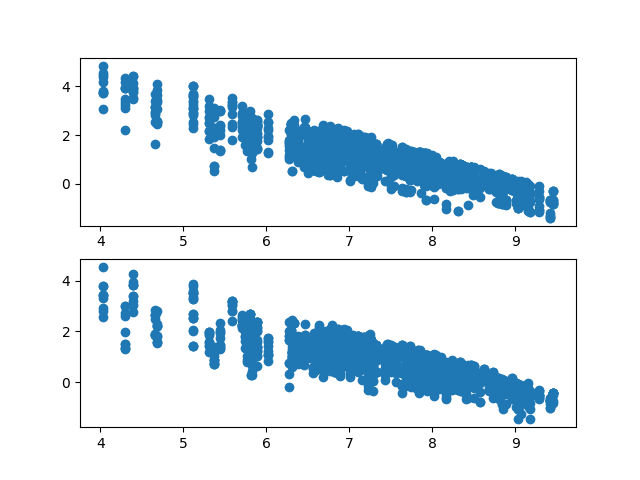

In [57]:
plt.close()
fig, axes = plt.subplots(2)
for i, ax in enumerate(axes):
  ax.scatter(a[i][0], a[i][1])
display(plt.show())

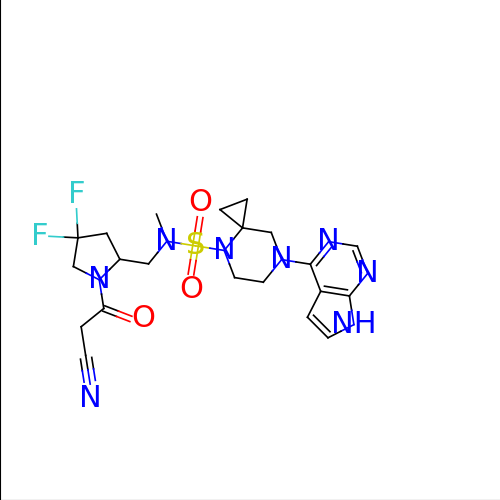

In [58]:
fig = Draw.MolToMPL(ms[1], size=(500,500))
ax = fig.axes[0]
ax.set_xlim(0,3)
ax.set_ylim(0,3)
display(fig.show())

# Virtual Screening

In [60]:
# sizes of the inactive compound seeds
all_bin = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','all_2188-sparse-regression.csv'))
train = pd.read_csv(os.path.join(G2G, 'train_set-all_targets.csv'))
print(all_bin.shape)
all_bin = all_bin[~all_bin.smiles.isin(train.SMILES)]
print(all_bin.shape)
print(all_bin.columns)
for col in all_bin.columns[1:]:
  inactives = all_bin[all_bin[col]<7.6]
  print(len(inactives))
  inactives.filter(['smiles']).to_csv(os.path.join(VIRTUAL_SCREENING,col+'_inactives-nontrain.smi'),index=False,header=None)

(2188, 5)
(361, 5)
Index(['smiles', 'JAK1', 'JAK2', 'JAK3', 'TYK2'], dtype='object')
185
204
297
334

In [61]:
valid_file = os.path.join(G2G, 'validation_set-all_targets.smi')
datasets = [#'dpEC1-all_pairs-JAK1.txt',
            #'dpEC1-close_pairs-JAK1.txt',
#             'dpEC1to2-all_pairs-JAK1.txt',
            'dpEC1to2-close_pairs-JAK1.txt',
            'dpEC1to2-close_pairs-TYK2.txt'#,
#             'median-all_pairs-JAK1.txt',
#             'median-close_pairs-JAK1.txt',
#             'pEC7.6-all_pairs-JAK1.txt',
#             'pEC7.6-close_pairs-JAK1.txt'
           ]

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
from copy import deepcopy
n_actives = '-all_inactives'
ITERATIONS = 10
#epochs = ['20','10']
n_samples = '10000'
targets =['JAK1', 'TYK2']
VS_Models = os.path.join(VIRTUAL_SCREENING,'models')
for j,dataset in enumerate(datasets):
    valid_file = os.path.join(VIRTUAL_SCREENING,targets[j]+'_inactives-nontrain.smi')
    all_actives = None
    for i in range(ITERATIONS):
      print('iteration:',i)
      # generation
      outpath = os.path.join(G2G,'models','10e-'+dataset[:-4],'iter'+str(i)+'validation_decoded-pairs'+n_actives+'.txt')#[:-4]
      arglist=['--test',valid_file
              ,'--vocab',os.path.join(G2G, 'molecules-all_targets.vocab')
              ,'--model',os.path.join(G2G,'models','10e-'+dataset[:-4],'model.iter-9')#[:-4]
              ,'--hidden_size','600'
              ,'--rand_size','22'
              ,'--share_embedding'
              ,'--use_molatt'
              ,'--num_decode','10'
              ]
      outlist = list(decode(arglist,outpath))

      
      #prediction
      outlist = [line.strip().split(' ') for line in open(os.path.join(G2G,'models','10e-'+dataset[:-4],'iter'+str(i)+'validation_decoded-pairs'+n_actives+'.txt'))]
      activity_score_l = activity_score(outlist,os.path.join(G2G,'models','10e-'+dataset[:-4]))#[:-4]

      #filtering
      preds = pd.read_csv(os.path.join(G2G,'models','10e-'+dataset[:-4],'translated.csv')).dropna().drop_duplicates(subset='smiles')
      actives = preds[preds[targets[j]]>=7]
      inactives = preds[~preds.smiles.isin(actives.smiles)]
      inactives = inactives.drop_duplicates(subset='smiles')
      actives.to_csv(os.path.join(G2G,'models','10e-'+dataset[:-4],'VS-iter-'+str(i)+'-actives'+n_actives+'.csv'),index=False)
      if all_actives is not None:
        all_actives = all_actives.append(actives.filter(['smiles'])).drop_duplicates()
        
      else:
        all_actives = deepcopy(actives.filter(['smiles']))
      valid_file = os.path.join(G2G,'models','10e-'+dataset[:-4],'VS-iter-'+str(i)+'-inactives'+n_actives+'.csv')
      inactives.filter(['smiles']).to_csv(valid_file,index=False,header=None)
      print('All active molecules:',len(all_actives))
      print('Active molecules this round:',len(actives))
      print('Inactive molecules:',len(inactives))

--------------------------------------------------------------------------- 
 FileNotFoundError Traceback (most recent call last)
 <command-3516997625570417> in <module> () 
 47 , '--num_decode' , '10' 
 48 ]
 ---> 49 outlist = list ( decode ( arglist , outpath ) ) 
 50 
 51 

 <command-1451287340670403> in decode (arglist, outpath, ringoption) 
 30 model . load_state_dict ( torch . load ( args . model ) ) 
 31 
 ---> 32 with open ( args . test ) as f : 
 33 datatext = [ line . split ( ) [ 0 ] for line in f ] 
 34 

 FileNotFoundError : [Errno 2] No such file or directory: '/dbfs/FileStore/ZINC/virtual_screening/VS-iter-7-inactives-all_inactives.csv'

In [62]:
import os
valid_file = os.path.join(G2G, 'validation_set-all_targets.smi')
datasets = ['dpEC1-all_pairs-JAK1.txt',
            'dpEC1-close_pairs-JAK1.txt',
            'dpEC1to2-all_pairs-JAK1.txt',
            'dpEC1to2-close_pairs-JAK1.txt',
            'median-all_pairs-JAK1.txt',
            'median-close_pairs-JAK1.txt',
            'pEC7.6-all_pairs-JAK1.txt',
            'pEC7.6-close_pairs-JAK1.txt']
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
res = []
for j,dataset in enumerate(datasets):
    outlist = [line.strip().split(' ') for line in open(os.path.join(G2G,'models','test-2e-'+dataset[:-4],'validation_decoded-pairs.txt'))]
    activity_score_l = activity_score(outlist,os.path.join(G2G,'models','test-2e-'+dataset[:-4]))
    property_increase = [prop for x,y,sim,prop in activity_score_l]
    sims_mean = np.mean([sim for x,y,sim,prop in activity_score_l])
    sims_std = np.std([sim for x,y,sim,prop in activity_score_l])
    avg_prop = np.mean(property_increase)
    std_prop = np.std(property_increase)
    mean_div, std_div, n_succ = diversity(activity_score_l)
    train_pair = [line.strip().split() for line in open(os.path.join(G2G,dataset),'r')]
    avg_novelty = novelty(list(outlist), train_pair)
    res.append((avg_prop,std_prop,mean_div, std_div, n_succ,avg_novelty,sims_mean,sims_std))

pickle.dump(res,open(os.path.join(G2G,'test-2e-validation.p'),'wb'))

--------------------------------------------------------------------------- 
 KeyError Traceback (most recent call last)
 /databricks/python/lib/python3.7/site-packages/pandas/core/indexes/base.py in get_loc (self, key, method, tolerance) 
 2656 try : 
 -> 2657 return self . _engine . get_loc ( key ) 
 2658 except KeyError : 

 pandas/_libs/index.pyx in pandas._libs.index.IndexEngine.get_loc () 

 pandas/_libs/index.pyx in pandas._libs.index.IndexEngine.get_loc () 

 pandas/_libs/hashtable_class_helper.pxi in pandas._libs.hashtable.PyObjectHashTable.get_item () 

 pandas/_libs/hashtable_class_helper.pxi in pandas._libs.hashtable.PyObjectHashTable.get_item () 

 KeyError : 'JAK1'

During handling of the above exception, another exception occurred:

 KeyError Traceback (most recent call last)
 <command-359950018725890> in <module> 
 16 for j , dataset in enumerate ( datasets ) : 
 17 outlist = [ line . strip ( ) . split ( ' ' ) for line in open ( os . path . join ( G2G , 'models' , 'test-2e-' + dataset [ : - 4 ] , 'validation_decoded-pairs.txt' ) ) ] 
 ---> 18 activity_score_l = activity_score ( outlist , os . path . join ( G2G , 'models' , 'test-2e-' + dataset [ : - 4 ] ) ) 
 19 property_increase = [ prop for x , y , sim , prop in activity_score_l ] 
 20 sims_mean = np . mean ( [ sim for x , y , sim , prop in activity_score_l ] ) 

 <command-2874435606672019> in activity_score (generated_pairs, folder) 
 42 print ( len ( given_preds ) ) 
 43 print ( len ( translated_preds ) ) 
 ---> 44 diff = translated_preds [ targets [ 0 ] ] - given_preds [ targets [ 0 ] ] #names[0]]-given_preds[targets[0]] 
 45 #print(given_preds[targets[0]]) 
 46 #print(translated_preds[targets[0]]) 

 /databricks/python/lib/python3.7/site-packages/pandas/core/frame.py in __getitem__ (self, key) 
 2925 if self . columns . nlevels > 1 : 
 2926 return self . _getitem_multilevel ( key ) 
 -> 2927 indexer = self . columns . get_loc ( key ) 
 2928 if is_integer ( indexer ) : 
 2929 indexer = [ indexer ] 

 /databricks/python/lib/python3.7/site-packages/pandas/core/indexes/base.py in get_loc (self, key, method, tolerance) 
 2657 return self . _engine . get_loc ( key ) 
 2658 except KeyError : 
 -> 2659 return self . _engine . get_loc ( self . _maybe_cast_indexer ( key ) ) 
 2660 indexer = self . get_indexer ( [ key ] , method = method , tolerance = tolerance ) 
 2661 if indexer . ndim > 1 or indexer . size > 1 : 

 pandas/_libs/index.pyx in pandas._libs.index.IndexEngine.get_loc () 

 pandas/_libs/index.pyx in pandas._libs.index.IndexEngine.get_loc () 

 pandas/_libs/hashtable_class_helper.pxi in pandas._libs.hashtable.PyObjectHashTable.get_item () 

 pandas/_libs/hashtable_class_helper.pxi in pandas._libs.hashtable.PyObjectHashTable.get_item () 

 KeyError : 'JAK1'

In [63]:
res = pickle.load(open(os.path.join(G2G,'test-2e-validation.p'),'rb'))
results = pd.DataFrame(list(res))
results.columns = ['avg_prop','std_prop','mean_div', 'std_div', 'n_succ','avg_novelty','sims_mean','sims_std']
display(results)

avg_prop,std_prop,mean_div,std_div,n_succ,avg_novelty,sims_mean,sims_std
1.1124505464838619,0.9018223777655363,0.09099340934529661,0.1715187773182212,35,0.9958702064896755,0.39339165017104855,0.10024644015069283
1.309165542450788,0.9223188223404152,0.06393602948892585,0.14408917304212793,28,0.9946902654867257,0.44250743497111367,0.12514417482167253
1.1143598533534798,0.8012170936723978,0.13008758292504904,0.19106842467843957,53,0.9893805309734514,0.4098873127482428,0.1128173655823428
1.185152530801604,0.9404649362962106,0.06635552617469319,0.14950434902080853,25,0.9929203539823008,0.4465299603828436,0.12554128862610392
0.10683889153237762,1.2338238130838346,0.13186807054622818,0.23287345748775654,17,0.9919168591224018,0.4055180707641019,0.07770108233356174
0.7855079424657913,1.1661469392591264,0.1546277940654437,0.21677531588330484,42,0.9872979214780601,0.46766414933267403,0.13322011533995223
0.4258647841551437,1.0725194237781515,0.021668501762540728,0.11151770683695035,3,0.9972936400541272,0.4331846809357921,0.10225558672006374
0.6218412672271385,1.0855057128348702,0.07634864551631033,0.16163474036427586,23,0.9891745602165088,0.46763876976407964,0.12360793668028114


In [64]:
res_dev_hopt = pickle.load(open(os.path.join(G2G,'5e-validation-s03p05.p'),'rb'))
results = pd.DataFrame(list(res_dev_hopt))
results.columns = ['avg_prop','std_prop','mean_div', 'std_div', 'n_succ','avg_novelty','sims_mean','sims_std']
display(results)

avg_prop,std_prop,mean_div,std_div,n_succ,avg_novelty,sims_mean,sims_std
0.8735164020667611,0.998460555342624,0.48226007400967524,0.12328374404458126,146,0.871976401179941,0.48333539181091945,0.13425367364956625
0.859916810539326,0.8368701377513291,0.4434246222585257,0.1526636436767625,141,0.8525073746312685,0.49854221142828103,0.1438018318765882


In [65]:
res_dev_hopt = pickle.load(open(os.path.join(G2G,'test-2e-validation-hopt2e-vs-default.p'),'rb'))
results = pd.DataFrame(list(res_dev_hopt))
results.columns = ['avg_prop','std_prop','mean_div', 'std_div', 'n_succ','avg_novelty','sims_mean','sims_std']
display(results)

avg_prop,std_prop,mean_div,std_div,n_succ,avg_novelty,sims_mean,sims_std
0.6571489788038879,1.2000013444257973,0.09844453592641354,0.21131379807634054,16,0.9941002949852508,0.39955357693095406,0.10992462280397935
0.6741175169290065,1.2684377986320239,0.09748391004991719,0.2116288522705875,18,0.9982300884955753,0.37634676262896016,0.0913972780680932


# Hyperparameter opt

In [67]:
%sh 
cp /dbfs/FileStore/g2g/tensors/dpEC1to2-close_pairs-JAK1/dpEC1to2-close_pairs-JAK1-tensors-0.pkl /dbfs/FileStore/g2g/tensors/hopt/dpEC1to2-close_pairs-JAK1-tensors-0.pkl

Out[47]: '/dbfs/FileStore/g2g/models/hyperopt/JAK1/config.json'

In [68]:
from hyperopt import fmin, hp, tpe
from argparse import ArgumentParser, Namespace
from copy import deepcopy
from typing import Dict, Union
import json
def train_vae(args,log_file=None):
    lg = rdkit.RDLogger.logger() 
    lg.setLevel(rdkit.RDLogger.CRITICAL)

    
    print(args)

    vocab = [x.strip("\r\n ") for x in open(args.vocab)] 
    vocab = Vocab(vocab)

    model = DiffVAE(vocab, args).cuda()

    for param in model.parameters():
        if param.dim() == 1:
            nn.init.constant_(param, 0)
            #nn.init.constant(param,0)
        else:
            nn.init.xavier_normal_(param)
            #nn.init.xavier_normal(param)

    if args.load_epoch >= 0:
        model.load_state_dict(torch.load(args.save_dir + "/model.iter-" + str(args.load_epoch)))

    print( "Model #Params: %dK" % (sum([x.nelement() for x in model.parameters()]) / 1000,))

    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    scheduler = lr_scheduler.ExponentialLR(optimizer, args.anneal_rate)
    scheduler.step()

    PRINT_ITER = 20
    param_norm = lambda m: math.sqrt(sum([p.norm().item() ** 2 for p in m.parameters()]))
    grad_norm = lambda m: math.sqrt(sum([p.grad.norm().item() ** 2 for p in m.parameters() if p.grad is not None]))
    if log_file:
        of_connection = open(log_file, 'w')
        writer = csv.writer(of_connection)

        # Write the headers to the file
        writer.writerow(['loss', 'kl_div', 'wacc', 'tacc', 'sacc'])
    for epoch in range(args.load_epoch + 1, args.epoch):
        loader = PairTreeFolder(args.train, vocab, args.batch_size, num_workers=4)
        meters = np.zeros(4)

        for it, batch in enumerate(loader):
            x_batch, y_batch = batch
            try:
                model.zero_grad()
                loss, kl_div, wacc, tacc, sacc = model(x_batch, y_batch, args.beta)
                loss.backward()
            except Exception as e:
                print( e)
                continue

            nn.utils.clip_grad_norm_(model.parameters(), args.clip_norm)
            optimizer.step()

            meters = meters + np.array([kl_div, wacc * 100, tacc * 100, sacc * 100])
            if log_file:
                writer.writerow([loss, kl_div, wacc, tacc, sacc])
            if (it + 1) % PRINT_ITER == 0:
                meters /= PRINT_ITER
                print("KL: %.2f, Word: %.2f, Topo: %.2f, Assm: %.2f, PNorm: %.2f, GNorm: %.2f" % (meters[0], meters[1], meters[2], meters[3], param_norm(model), grad_norm(model)))
                sys.stdout.flush()
                meters *= 0

        scheduler.step()

        print( "learning rate: %.6f" % scheduler.get_lr()[0])
        if args.save_dir is not None:
            torch.save(model.state_dict(), args.save_dir + "/model.iter-" + str(epoch))
    return loss
def grid_search(args: Namespace, configpath):
    # Run grid search
    results = []
    from chemprop.utils import makedirs
    # Define hyperparameter optimization
    def objective(hyperparams: Dict[str, Union[int, float]]) -> float:
        # Convert hyperparams from float to int when necessary
        for key in INT_KEYS:
            hyperparams[key] = int(hyperparams[key])

        # Update args with hyperparams
        hyper_args = deepcopy(args)
        if args.save_dir is not None:
            folder_name = '_'.join(f'{key}_{value}' for key, value in hyperparams.items())
            hyper_args.save_dir = os.path.join(hyper_args.save_dir, folder_name)
        for key, value in hyperparams.items():
            setattr(hyper_args, key, value)

        # Record hyperparameters
        #logger.info(hyperparams)
        print(hyperparams)
        print(hyper_args)
        # Cross validate
        score = float(train_vae(hyper_args))
        #print(type(score))
        results.append({
            'loss': score,
            #'std_score': std_score,
            'hyperparams': hyperparams,
            #'num_params': num_params
        })
        return score
    
    fmin(objective, SPACE, algo=tpe.suggest, max_evals=num_iters)

    # Report best result
    results = [result for result in results if not np.isnan(result['loss'])]
    best_result = min(results, key=lambda result: result['loss'])
    # Save best hyperparameter settings as JSON config file
    makedirs(configpath, isfile=True)
    print('best result:',best_result)
    with open(configpath, 'w') as f:
        json.dump(best_result['hyperparams'], f, indent=4, sort_keys=True)


In [69]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
parser = argparse.ArgumentParser()
parser.add_argument('--train', required=True)
parser.add_argument('--vocab', required=True)
parser.add_argument('--save_dir', type=str, default=None)
parser.add_argument('--load_epoch', type=int, default=-1)

parser.add_argument('--hidden_size', type=int, default=300)
parser.add_argument('--batch_size', type=int, default=32)
parser.add_argument('--rand_size', type=int, default=8)
parser.add_argument('--depthT', type=int, default=6)
parser.add_argument('--depthG', type=int, default=3)
parser.add_argument('--share_embedding', action='store_true')
parser.add_argument('--use_molatt', action='store_true')

parser.add_argument('--clip_norm', type=float, default=50.0)
parser.add_argument('--beta', type=float, default=1.0)
parser.add_argument('--epoch', type=int, default=20)
parser.add_argument('--anneal_rate', type=float, default=0.9)
parser.add_argument('--lr', type=float, default=1e-3)

#warnings.warn = warn

SPACE = {
    'hidden_size': hp.quniform('hidden_size', low=120, high=600, q=40),
    'rand_size': hp.quniform('rand_size', low=4, high=24, q=2),
    'depthT': hp.quniform('depthT', low=4, high=8, q=1),
    'depthG': hp.quniform('depthG', low=1, high=5, q=1)
}
INT_KEYS = ['hidden_size', 'rand_size', 'depthT','depthG']

arglist=input_args = ['--train','/dbfs/FileStore/g2g/tensors/hopt/'
                     ,'--vocab',os.path.join(G2G, 'molecules-JAK1.vocab')
                     #,'--save_dir',os.path.join(G2G,'models','hyperopt/JAK1')
#                       ,'--hidden_size','330'
#                       ,'--rand_size','16'
                     ,'--epoch','2'
                     ,'--anneal_rate','0.2'
                     ,'--batch_size','64'
                     ,'--share_embedding'
                     ,'--use_molatt']
args = parser.parse_args(arglist)
num_iters = 30
grid_search(args,os.path.join(G2G,'models','hyperopt/JAK1/hopt-2e.json'))

0%| | 0/30 [00:00<?, ?it/s, best loss: ?] 
 {'depthG': 5, 'depthT': 6, 'hidden_size': 200, 'rand_size': 6}
 19%|█▉ | 343/1819 [13:04<00:00, 3423.98it/s]
 0%| | 0/30 [00:00<?, ?it/s, best loss: ?] 
 Namespace(anneal_rate=0.2, batch_size=64, beta=1.0, clip_norm=50.0, depthG=5, depthT=6, epoch=2, hidden_size=200, load_epoch=-1, lr=0.001, rand_size=6, save_dir=None, share_embedding=True, train='/dbfs/FileStore/g2g/tensors/hopt/', use_molatt=True, vocab='/dbfs/FileStore/g2g/molecules-JAK1.vocab')
 19%|█▉ | 343/1819 [13:04<00:00, 3423.98it/s]
 0%| | 0/30 [00:00<?, ?it/s, best loss: ?] 
 Namespace(anneal_rate=0.2, batch_size=64, beta=1.0, clip_norm=50.0, depthG=5, depthT=6, epoch=2, hidden_size=200, load_epoch=-1, lr=0.001, rand_size=6, save_dir=None, share_embedding=True, train='/dbfs/FileStore/g2g/tensors/hopt/', use_molatt=True, vocab='/dbfs/FileStore/g2g/molecules-JAK1.vocab')
 19%|█▉ | 343/1819 [13:04<00:00, 3423.98it/s]
 0%| | 0/30 [00:00<?, ?it/s, best loss: ?] 
 Model #Params: 1395K
 19%|█▉ | 343/1819 [13:04<00:00, 3423.98it/s]
 0%| | 0/30 [00:00<?, ?it/s, best loss: ?] 
 KL: 0.00, Word: 14.66, Topo: 60.60, Assm: 84.46, PNorm: 75.29, GNorm: 50.00
 19%|█▉ | 343/1819 [14:09<00:00, 3423.98it/s]
 0%| | 0/30 [01:04<?, ?it/s, best loss: ?] 
 KL: 0.01, Word: 16.06, Topo: 79.23, Assm: 91.91, PNorm: 75.39, GNorm: 50.00
 19%|█▉ | 343/1819 [14:54<00:00, 3423.98it/s]
 0%| | 0/30 [01:50<?, ?it/s, best loss: ?] 
 KL: 0.02, Word: 17.76, Topo: 94.17, Assm: 93.50, PNorm: 75.51, GNorm: 50.00
 19%|█▉ | 343/1819 [15:37<00:00, 3423.98it/s]
 0%| | 0/30 [02:32<?, ?it/s, best loss: ?] 
 KL: 0.02, Word: 27.81, Topo: 95.90, Assm: 94.00, PNorm: 75.60, GNorm: 50.00
 19%|█▉ | 343/1819 [16:26<00:00, 3423.98it/s]
 0%| | 0/30 [03:22<?, ?it/s, best loss: ?] 
 KL: 0.02, Word: 36.91, Topo: 96.96, Assm: 93.74, PNorm: 75.73, GNorm: 50.00
 19%|█▉ | 343/1819 [17:20<00:00, 3423.98it/s]
 0%| | 0/30 [04:16<?, ?it/s, best loss: ?] 
 KL: 0.02, Word: 45.61, Topo: 97.21, Assm: 93.74, PNorm: 75.85, GNorm: 50.00
 19%|█▉ | 343/1819 [18:23<00:00, 3423.98it/s]
 0%| | 0/30 [05:18<?, ?it/s, best loss: ?] 
 KL: 0.02, Word: 51.52, Topo: 97.53, Assm: 93.65, PNorm: 75.93, GNorm: 50.00
 19%|█▉ | 343/1819 [19:20<00:00, 3423.98it/s]
 0%| | 0/30 [06:16<?, ?it/s, best loss: ?] 
 learning rate: 0.000008
 19%|█▉ | 343/1819 [20:00<00:00, 3423.98it/s]
 0%| | 0/30 [06:56<?, ?it/s, best loss: ?] 
 KL: 0.02, Word: 56.20, Topo: 98.26, Assm: 95.17, PNorm: 76.03, GNorm: 50.00
 19%|█▉ | 343/1819 [21:22<00:00, 3423.98it/s]
 0%| | 0/30 [08:18<?, ?it/s, best loss: ?] 
 KL: 0.02, Word: 57.74, Topo: 98.28, Assm: 95.35, PNorm: 76.05, GNorm: 50.00
 19%|█▉ | 343/1819 [22:08<00:00, 3423.98it/s]
 0%| | 0/30 [09:03<?, ?it/s, best loss: ?] 
 KL: 0.02, Word: 59.18, Topo: 98.33, Assm: 95.08, PNorm: 76.07, GNorm: 50.00
 19%|█▉ | 343/1819 [22:59<00:00, 3423.98it/s]
 0%| | 0/30 [09:55<?, ?it/s, best loss: ?] 
 KL: 0.03, Word: 59.23, Topo: 98.30, Assm: 96.09, PNorm: 76.09, GNorm: 50.00
 19%|█▉ | 343/1819 [23:43<00:00, 3423.98it/s]
 0%| | 0/30 [10:39<?, ?it/s, best loss: ?] 
 KL: 0.02, Word: 60.95, Topo: 98.43, Assm: 95.91, PNorm: 76.11, GNorm: 50.00
 19%|█▉ | 343/1819 [24:26<00:00, 3423.98it/s]
 0%| | 0/30 [11:22<?, ?it/s, best loss: ?] 
 KL: 0.02, Word: 61.74, Topo: 98.32, Assm: 95.58, PNorm: 76.13, GNorm: 50.00
 19%|█▉ | 343/1819 [25:17<00:00, 3423.98it/s]
 0%| | 0/30 [12:13<?, ?it/s, best loss: ?] 
 KL: 0.02, Word: 62.94, Topo: 98.45, Assm: 95.56, PNorm: 76.15, GNorm: 50.00
 19%|█▉ | 343/1819 [26:03<00:00, 3423.98it/s]
 0%| | 0/30 [12:59<?, ?it/s, best loss: ?] 
 learning rate: 0.000002
 19%|█▉ | 343/1819 [26:41<00:00, 3423.98it/s]
 0%| | 0/30 [13:37<?, ?it/s, best loss: ?]
 3%|▎ | 1/30 [13:37<6:34:53, 817.03s/it, best loss: 23.94770622253418] 
 {'depthG': 3, 'depthT': 7, 'hidden_size': 760, 'rand_size': 12}
 19%|█▉ | 343/1819 [26:41<00:00, 3423.98it/s]
 3%|▎ | 1/30 [13:37<6:34:53, 817.0

In [70]:
%sh cat /dbfs/FileStore/g2g/models/hyperopt/JAK1/config.json

{
 "depthG": 3,
 "depthT": 6,
 "hidden_size": 600,
 "rand_size": 22
}